In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import stationarity_tests, stationarity_test_adf, stationarity_test_kpss, check_seasonality
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.covariance import MinCovDet
import warnings
warnings.filterwarnings('ignore')
from itertools import product
from tqdm import tqdm
from pytorch_lightning.callbacks import LearningRateMonitor
import glob
import shutil
import os
from sklearn.preprocessing import RobustScaler
import pickle
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pytorch_lightning.callbacks import Callback
from darts import utils
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from datetime import datetime
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

from darts.models import TransformerModel
from darts.metrics import mae
import torch
torch.set_default_dtype(torch.float32)

from sklearn.metrics import confusion_matrix
from tqdm import tqdm

from pytorch_lightning.callbacks import EarlyStopping

from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix


# 2. Обучение модели

## 2.1. Общая архитектура обучения

Обучение представляет собой многоэтапный процесс последовательного обучения и дообучения (continual learning) модели Transformer на хронологически упорядоченных сегментах временных рядов. Данный подход обеспечивает адаптацию модели к изменяющимся условиям эксплуатации технологического оборудования.

## 2.2. Конфигурация обучения

Для обеспечения стабильности и эффективности обучения реализованы следующие механизмы:

- **Мониторинг скорости обучения**: Callback-функция `LearningRateMonitor` отслеживает динамику изменения learning rate
- **Ранняя остановка**: `EarlyStopping` прекращает обучение при отсутствии улучшений на валидационной выборке в течение 10 эпох
- **Сохранение моделей**: `ModelCheckpoint` сохраняет 3 лучшие версии модели по метрике `val_loss`
- **Логирование метрик**: Настроено параллельное логирование в CSV-файлы и TensorBoard для последующего анализа

## 2.3. Архитектура модели Transformer

Модель построена на основе encoder-decoder архитектуры со следующими характеристиками:

- **Структура**: 2 энкодерных слоя и 1 декодерный слой для эффективной обработки временных зависимостей
- **Механизм внимания**: Multi-head attention с 4 головами для параллельного анализа различных временных паттернов
- **Размерность модели**:
  - `d_model=128` — размерность скрытых представлений
  - `dim_feedforward=512` — размерность полносвязного слоя в feed-forward сети
- **Регуляризация**:
  - Dropout с вероятностью 0.1
  - L2-регуляризация с коэффициентом `weight_decay=1e-4`
- **Функция активации**: ReLU для обеспечения нелинейности и вычислительной эффективности
- **Оптимизация**: Косинусное затухание скорости обучения (`CosineAnnealingLR`) с периодом 50 эпох

## 2.4. Предобработка данных

Исходные диагностические параметры (142 признака) характеризуются различной физической природой, что приводит к значительным различиям в диапазонах значений и дисперсии. Для обеспечения корректной работы алгоритмов градиентной оптимизации выполнена нормализация данных:

- **Метод нормализации**: `QuantileTransformer` преобразует распределение признаков в равномерное, снижая чувствительность к выбросам
- **Стратегия применения**: Единый объект `Scaler` обучается на объединённых данных всех тренировочных сегментов, что обеспечивает консистентность преобразований
- **Сохранение состояния**: Обученный scaler сериализуется для последующего использования на новых данных

## 2.5. Механизм непрерывного обучения

Реализован пошаговый процесс обучения на последовательных сегментах данных:

- **Первоначальное обучение**: Полное обучение на первом сегменте с валидацией
- **Дообучение**: Fine-tuning на последующих сегментах с уменьшенной скоростью обучения
- **Сохранение состояния**: Чекпоинты модели сохраняются после обработки каждого сегмента

## 2.6. Разделение данных на выборки

Функция `safe_split()` реализует интеллектуальное разделение с проверкой минимальных требований:

- **Обучающая выборка**: Минимум `input_chunk + output_chunk` шагов
- **Валидационная выборка**: Минимум `input_chunk + 200` шагов (не менее 200 прогнозов)
- **Адаптивная логика**: При недостаточном объёме данных валидационная выборка не формируется
- **Автоматическое масштабирование**: Размеры выборок адаптируются в зависимости от доступного объёма данных

In [ ]:
# чтение данных
dataset = pd.read_csv('dataset.csv', encoding = 'Windows-1251', index_col = 0, parse_dates = True)
stops = pd.read_csv('stops.csv', index_col = 0, parse_dates = True, date_format=lambda x: pd.to_datetime(x, format='%d.%m.%y %H:%M'))


# from google.colab import drive
# drive.mount('/content/drive')

# drive_path = '/content/drive/MyDrive/'

# # Чтение данных с Google Диска
# dataset = pd.read_csv(
#     drive_path + 'dataset.csv',
#     encoding='Windows-1251',
#     index_col=0,
#     parse_dates=True
# )

# stops = pd.read_csv(
#     drive_path + 'stops.csv',
#     encoding='Windows-1251',  # добавлено, так как в исходном коде был Windows-1251
#     index_col=0,
#     parse_dates=True,
#     date_format=lambda x: pd.to_datetime(x, format='%d.%m.%y %H:%M')
# )


# объединение датасета меток и показаний датчиков

stops = stops.reset_index()
d = {'vibrosito' : 1, 'stop' : 1}
stops = stops.replace({'type': d})
stops.date = pd.to_datetime(stops.date)
result = pd.merge(dataset, stops, how='left', on='date')
result.type = result.type.fillna(0)

# обрезание части датасета (так как в ней очень много пропусков)

first_valid_index = result[~(result.fillna(-1) == -1).any(axis=1)].index[0]
result = result.loc[first_valid_index:].copy()

# переименовываем таргет

result['target'] = result['type']
result = result.drop("type",axis=1)

# агрегация данных в 10-минутные точки

result = result.set_index('date').sort_index()
aggregated = result.resample("10Min").agg(['max', 'min', 'mean'])
aggregated.columns = [f'{col}_{stat}' for col, stat in aggregated.columns]
df = aggregated
# так как в датасете буквально в паре колонок остались пробелы в 72 точки, было принято решение закрасить их предыдущим значением
df = df.ffill()

# избавляемся от лишних колонок
df = df.drop(["target_min","target_mean"],axis=1)
df = df.rename(columns={'target_max': 'target'})

# анализ сезонности показал присутствие значимой месячной сезонности
# поэтому принято решение добавить в датасет ohe месяца
# а потом использовать их в качестве ковариат

df['month'] = df.index.month

all_months_dummies = pd.get_dummies(df['month'], prefix='month')

for m in range(1, 13):
    col_name = f'month_{m}'
    if col_name not in all_months_dummies.columns:
        all_months_dummies[col_name] = 0

all_months_dummies = all_months_dummies.reindex(
    columns=[f'month_{i}' for i in range(1, 13)]
)

df = pd.concat([df, all_months_dummies], axis=1)
df = df.drop('month', axis=1)

# ГИПЕРПАРАМЕТРЫ

# дата разделения данных (слева остаются данные для обучения, справа для теста)
split_date = pd.Timestamp('2017-03-06')

# даем модели недельный контекст
input_chunk = 288

# получаем прогноз на 1 день
output_chunk = 1

# вырезаемые точки вокруг аномалий (для очистки левой половины ВР для обучения на нормальный данных)
buffer_before = 48*6
buffer_after = 36

# минимальный "чистый" сегмент
min_segment = 288

top_n_segments = 3

initial_epochs_with_val = 300 # Для обучения с валидацией
initial_epochs_without_val = 12 # Для обучения без валидации
finetune_epochs = 150 # Для fine-tuning

initial_lr = 1e-4 # Начальный learning rate
finetune_lr = 5e-5 # Learning rate для fine-tuning



feature_cols = df.columns[:129]
target_col = df.columns[129]
covariate_cols = df.columns[130:]

# находим чистые сегменты
labels = df[target_col].values.astype(int)
mask = np.zeros(len(labels), dtype=bool)
i = 1
while i < len(labels):
    if labels[i] == 1 and labels[i-1] == 0:
        j = i
        while j < len(labels) and labels[j] == 1:
            j += 1
        s = max(0, i - buffer_before)
        e = min(len(labels), j + buffer_after)
        mask[s:e] = True
        i = j
    else:
        i += 1

segments = []
cur = None
for idx in range(len(mask)):
    if not mask[idx]:
        if cur is None:
            cur = idx
    else:
        if cur is not None:
            L = idx - cur
            if L >= min_segment:
                seg_df = df.iloc[cur:idx]
                start_time = pd.Timestamp(seg_df.index[0]) if hasattr(seg_df.index, '__getitem__') else None
                segments.append({'data': seg_df, 'start_time': start_time, 'length': L})
            cur = None
if cur is not None:
    L = len(mask) - cur
    if L >= min_segment:
        seg_df = df.iloc[cur:]
        start_time = pd.Timestamp(seg_df.index[0]) if hasattr(seg_df.index, '__getitem__') else None
        segments.append({'data': seg_df, 'start_time': start_time, 'length': L})

if len(segments) == 0:
    raise RuntimeError("No clean segments found. Adjust buffer or min_segment.")

# берем на рассмотрение только чистые части до split_date
train_segs = [s for s in segments if (s['start_time'] is None) or (s['start_time'] < split_date)]
if len(train_segs) == 0:
    train_segs = segments

# выбираем топ самых длинных
train_segs.sort(key=lambda x: x['length'], reverse=True)
selected = train_segs[:top_n_segments]
selected.sort(key=lambda x: x['start_time'] if x['start_time'] is not None else pd.Timestamp.min)

print(f"Selected {len(selected)} segments for sequential training (lengths): {[s['length'] for s in selected]}")


#sheduler
lr_monitor = LearningRateMonitor(logging_interval='epoch')

# модель и скалер
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1e-4,
    mode="min",
    verbose=False
)

checkpoint_callback = ModelCheckpoint(
    dirpath="./model_checkpoints",
    monitor="val_loss",
    mode="min",
    save_top_k=3,
    filename="best-{epoch:02d}-{val_loss:.4f}"
)

csv_logger = CSVLogger(save_dir="./logs", name="darts_logs")
tensorboard_logger = TensorBoardLogger(save_dir="./logs", name="darts_tb")

# Базовые настройки с основными callbacks
base_trainer_kwargs = {
    "accelerator": "cuda",
    "devices": 1,
    "precision": 32,
    "logger": [csv_logger, tensorboard_logger],
    "callbacks": [lr_monitor],
    "enable_progress_bar": True,
    "enable_model_summary": True,
    "log_every_n_steps": 10,
}

model = TransformerModel(
    input_chunk_length=input_chunk,
    output_chunk_length=output_chunk,
    d_model = 128,
    dim_feedforward = 512,
    dropout=0.1,
    activation="relu",
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=1,
    batch_size=32,
    n_epochs=initial_epochs_with_val,
    random_state=42,
    optimizer_kwargs={
        "lr": initial_lr,
        "weight_decay": 1e-4  # L2 регуляризация
    },
    lr_scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR,
    lr_scheduler_kwargs={"T_max": 50},
    pl_trainer_kwargs=base_trainer_kwargs,
    model_name="transformer_ad_continual",
    force_reset=True,
)

# функция для разделения данных
def safe_split(series, covs, input_chunk, output_chunk, val_frac):
    """
    Безопасное разделение с проверкой валидации
    """
    min_required_train = input_chunk + output_chunk  # 1009 для train
    min_required_val = input_chunk + 200  # 1208 для val (минимум 200 предсказаний)

    # 1. Если весь сегмент слишком короткий для train - пропускаем
    if len(series) < min_required_train:
        print(f" Сегмент слишком короткий ({len(series)} < {min_required_train}) - пропускаем")
        return None, None, None, None

    # 2. Если сегмент < 2500 - без валидации (и так мало данных)
    if len(series) < 2500:
        print(f" Сегмент короткий ({len(series)} < 2500) - без валидации")
        return series, None, covs, None

    # 3. Пытаемся создать валидацию по val_frac
    val_len = int(len(series) * (1 - val_frac))

    # Если валидация слишком короткая для надежной оценки
    if val_len < min_required_val:
        print(f" Валидация слишком короткая ({val_len} < {min_required_val})")

        # Проверяем, можно ли создать минимальную валидацию
        if len(series) >= min_required_train + min_required_val:
            val_len = min_required_val
            train_len = len(series) - val_len

            if train_len >= min_required_train:
                print(f" Создаем минимальную валидацию: train={train_len}, val={val_len}")

                split_point = train_len
                train_series = series[:split_point]
                val_series = series[split_point:]

                if covs is not None:
                    train_cov = covs[:split_point]
                    val_cov = covs[split_point:]
                else:
                    train_cov = val_cov = None

                return train_series, val_series, train_cov, val_cov

        # Не можем создать надежную валидацию
        print(f" Без валидации (нужно >= {min_required_train + min_required_val} шагов)")
        return series, None, covs, None

    # 4. Проверяем train часть
    train_len = len(series) - val_len
    if train_len < min_required_train:
        print(f" Train слишком короткий ({train_len} < {min_required_train})")

        # Уменьшаем валидацию до минимума
        if len(series) >= min_required_train + min_required_val:
            val_len = min_required_val
            train_len = len(series) - val_len
            print(f" Уменьшаем валидацию до {val_len}, train={train_len}")

            split_point = train_len
            train_series = series[:split_point]
            val_series = series[split_point:]

            if covs is not None:
                train_cov = covs[:split_point]
                val_cov = covs[split_point:]
            else:
                train_cov = val_cov = None

            return train_series, val_series, train_cov, val_cov
        else:
            print(f" Без валидации (нужно >= {min_required_train + min_required_val} шагов)")
            return series, None, covs, None

    # 5. Все ок, выполняем стандартное разделение
    split_point = train_len
    train_series = series[:split_point]
    val_series = series[split_point:]

    if covs is not None:
        train_cov = covs[:split_point]
        val_cov = covs[split_point:]
    else:
        train_cov = val_cov = None

    val_predictions = val_len - input_chunk
    print(f" Стандартное разделение: train={train_len} ({train_len/len(series)*100:.1f}%), "
          f"val={val_len} ({val_len/len(series)*100:.1f}%)")
    print(f" Val предсказаний: {val_predictions}")

    return train_series, val_series, train_cov, val_cov

# функция для вычисления остатков
def rolling_residuals(series, covs, model, input_chunk):
    residuals = []
    times = []
    n = len(series)

    for start in tqdm(range(0, n - input_chunk - 1), desc="Rolling residuals"):
        hist = series[start:start+input_chunk]

        if covs is not None:
            hist_cov = covs[start:start+input_chunk+1]
        else:
            hist_cov = None

        forecast = model.predict(
            n=1,
            series=hist,
            past_covariates=hist_cov,
            show_warnings=False,
            verbose=False
        )

        actual = series[start+input_chunk:start+input_chunk+1]
        res = (forecast.values()[0] - actual.values()[0]).astype(np.float32)
        residuals.append(res)
        times.append(series.time_index[start+input_chunk])

    return np.array(residuals, dtype=np.float32), np.array(times)


scaler_dir = "./scalers"
scaler_path = os.path.join(scaler_dir, "scaler.pkl")

# 1. Пытаемся загрузить существующий scaler
if os.path.exists(scaler_path):
    try:
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        print(f"✓ Scaler загружен из {scaler_path}")
    except Exception as e:
        print(f"! Ошибка при загрузке scaler: {e}. Будет обучен новый.")
        scaler = None
else:
    scaler = None
# 2. Если scaler не загружен - обучаем новый
if scaler is None:
    print("Обучение нового scaler...")

    # Создаём папку, если её нет
    os.makedirs(scaler_dir, exist_ok=True)

    # Собираем чистые тренировочные данные
    train_dfs = []
    for seg in selected:
        train_dfs.append(seg['data'][feature_cols])

    train_clean_df = pd.concat(train_dfs, axis=0).sort_index()
    train_clean_ts = TimeSeries.from_dataframe(
        train_clean_df,
        freq='10Min'
    ).astype(np.float32)

    n_samples = len(train_clean_ts)
    n_quantiles_to_use = min(1000, n_samples)

    quantile_transformer = QuantileTransformer(
        output_distribution='uniform',
        n_quantiles=n_quantiles_to_use,
        random_state=42,
        subsample=int(1e9)
    )

    # Обучаем и сохраняем scaler
    scaler = Scaler(quantile_transformer)
    scaler.fit(train_clean_ts)

    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

# ура, обучаем модель

first = True
last_val_ts = None
last_val_cov = None

# Директория для чекпоинтов
checkpoint_dir = "./checkpoints"
checkpoint_pattern = os.path.join(checkpoint_dir, "checkpoint_*.pt")

for idx, seg in enumerate(selected):
    # Если это первый сегмент - очищаем старые чекпоинты
    if first:
        # Очищаем директорию или удаляем старые файлы
        if os.path.exists(checkpoint_dir):
            # Вариант 1: Удалить всю директорию и создать заново
            shutil.rmtree(checkpoint_dir)
            os.makedirs(checkpoint_dir, exist_ok=True)
            print("Cleaned checkpoint directory")
        else:
            os.makedirs(checkpoint_dir, exist_ok=True)

    seg_df = seg['data']
    ts = TimeSeries.from_dataframe(seg_df[feature_cols], freq='10Min').astype(np.float32)
    cov = TimeSeries.from_dataframe(seg_df[covariate_cols], freq='10Min').astype(np.float32) if len(covariate_cols)>0 else None

    scaled = scaler.transform(ts).astype(np.float32)

    train_ts, val_ts, train_cov, val_cov = safe_split(
        scaled,
        cov,
        input_chunk,
        output_chunk,
        val_frac
    )

    if train_ts is None:
        print(f" Пропускаем сегмент {idx+1} - слишком короткий для обучения")
        continue

    if val_ts is not None:
        last_val_ts = val_ts
        last_val_cov = val_cov
        print(f" Saved validation data (len={len(val_ts)})")
    else:
        print(f" No validation data for this segment")

# Проверяем, есть ли чекпоинт для продолжения обучения
    checkpoint_files = glob.glob(checkpoint_pattern)

    if not first and checkpoint_files:
        # Находим последний чекпоинт
        latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
        print(f"Loading from checkpoint: {latest_checkpoint}")

        # Загружаем модель из чекпоинта
        try:
            model = TransformerModel.load(latest_checkpoint)
            model.force_reset = False
            print(f"Resumed training from checkpoint")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            # Продолжаем с текущей моделью

    if first:
        print(f"Stage {idx+1}/{len(selected)} — training from scratch on segment (len={len(ts)})")

        if val_ts is not None:
            # Создаем копию base_trainer_kwargs и добавляем early_stopping
            current_trainer_kwargs = base_trainer_kwargs.copy()
            current_trainer_kwargs["callbacks"] = (
                current_trainer_kwargs.get("callbacks", []) + [early_stopping]
            )
            model.pl_trainer_kwargs = current_trainer_kwargs

            model.fit(
                series=train_ts,
                past_covariates=train_cov,
                val_series=val_ts,
                val_past_covariates=val_cov,
                verbose=True
            )
        else:
            # Используем base_trainer_kwargs без изменений (без early_stopping)
            model.pl_trainer_kwargs = base_trainer_kwargs.copy()
            model.fit(
                series=train_ts,
                past_covariates=train_cov,
                verbose=True
            )

        first = False
        model.force_reset = False
    else:
        print(f"Stage {idx+1}/{len(selected)} — fine-tuning on segment (len={len(ts)})")

        # 1. МЕНЬШЕ эпох для fine-tuning
        model.n_epochs = finetune_epochs  # например, 10 вместо 50

        # 2. МЕНЬШЕ learning rate для fine-tuning
        model.optimizer_kwargs = {"lr": finetune_lr}  # например, 0.0001 вместо 0.001

        # 3. Более строгий early stopping (меньше patience)
        if val_ts is not None:
            # Создаем копию и добавляем early_stopping для fine-tuning
            current_trainer_kwargs = base_trainer_kwargs.copy()

            # Меньше patience для fine-tuning
            finetune_early_stopping = EarlyStopping(
                monitor="val_loss",
                patience=5,  # Меньше, чем в начальном обучении (там было 10)
                min_delta=1e-4,
                mode="min",
                verbose=False
            )

            current_trainer_kwargs["callbacks"] = (
                current_trainer_kwargs.get("callbacks", []) + [finetune_early_stopping]
            )
            model.pl_trainer_kwargs = current_trainer_kwargs

            print(" Fine-tuning with validation")
            model.fit(
                series=train_ts,
                past_covariates=train_cov,
                val_series=val_ts,
                val_past_covariates=val_cov,
                verbose=True
            )
        else:
            # Без валидации - еще меньше LR
            model.optimizer_kwargs = {"lr": finetune_lr * 0.5}  # Вдвое меньше
            model.pl_trainer_kwargs = base_trainer_kwargs.copy()

            print(f" Fine-tuning WITHOUT validation - {finetune_epochs} epochs with smaller LR")
            model.fit(
                series=train_ts,
                past_covariates=train_cov,
                verbose=True
            )

    # Сохраняем чекпоинт после каждого сегмента
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_{idx}.pt")
    model.save(checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")

Selected 4 segments for sequential training (lengths): [2624, 3328, 845, 3449]
✓ Scaler загружен из ./scalers\scaler.pkl
Cleaned checkpoint directory
 Стандартное разделение: train=2100 (80.0%), val=524 (20.0%)
 Val предсказаний: 236
 Saved validation data (len=524)
Stage 1/4 — training from scratch on segment (len=2624)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Saved checkpoint: ./checkpoints\checkpoint_0.pt
 Стандартное разделение: train=2663 (80.0%), val=665 (20.0%)
 Val предсказаний: 377
 Saved validation data (len=665)
Loading from checkpoint: ./checkpoints\checkpoint_0.pt
Resumed training from checkpoint
Stage 2/4 — fine-tuning on segment (len=3328)
 Fine-tuning with validation


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Saved checkpoint: ./checkpoints\checkpoint_1.pt
 Сегмент короткий (845 < 2500) - без валидации
 No validation data for this segment
Loading from checkpoint: ./checkpoints\checkpoint_1.pt
Resumed training from checkpoint
Stage 3/4 — fine-tuning on segment (len=845)
 Fine-tuning WITHOUT validation - 150 epochs with smaller LR


Training: |                                                                                      | 0/? [00:00<…

Saved checkpoint: ./checkpoints\checkpoint_2.pt
 Стандартное разделение: train=2760 (80.0%), val=689 (20.0%)
 Val предсказаний: 401
 Saved validation data (len=689)
Loading from checkpoint: ./checkpoints\checkpoint_2.pt
Resumed training from checkpoint
Stage 4/4 — fine-tuning on segment (len=3449)
 Fine-tuning with validation


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Saved checkpoint: ./checkpoints\checkpoint_3.pt


In [ ]:
print(feature_cols,
target_col,
covariate_cols)

Index(['RF.21304.Ток...213MII904A_max', 'RF.21304.Ток...213MII904A_min',
       'RF.21304.Ток...213MII904A_mean', 'S.C.ВПУСК.ПП.ДАВЛ...214PI226AA_max',
       'S.C.ВПУСК.ПП.ДАВЛ...214PI226AA_min',
       'S.C.ВПУСК.ПП.ДАВЛ...214PI226AA_mean',
       'S.C.ВПУСК.ПП.ДАВЛ...214PI226AB_max',
       'S.C.ВПУСК.ПП.ДАВЛ...214PI226AB_min',
       'S.C.ВПУСК.ПП.ДАВЛ...214PI226AB_mean',
       'S.C.ВПУСК.ПП.ТЕМП...214TI232A_max',
       ...
       'ЦИЛ..9.ТЕМП.УПР...214TIC213A_mean',
       'ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A_max',
       'ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A_min',
       'ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A_mean',
       'ЭКСТР.ДВИГ.ПОТОК...214II200A_max', 'ЭКСТР.ДВИГ.ПОТОК...214II200A_min',
       'ЭКСТР.ДВИГ.ПОТОК...214II200A_mean',
       'H2.C3..КОНТР.СООТН...212AIC008.PV_max',
       'H2.C3..КОНТР.СООТН...212AIC008.PV_min',
       'H2.C3..КОНТР.СООТН...212AIC008.PV_mean'],
      dtype='object', length=129) target Index(['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
      

### Скриншоты процесса обучения из TensorBoard

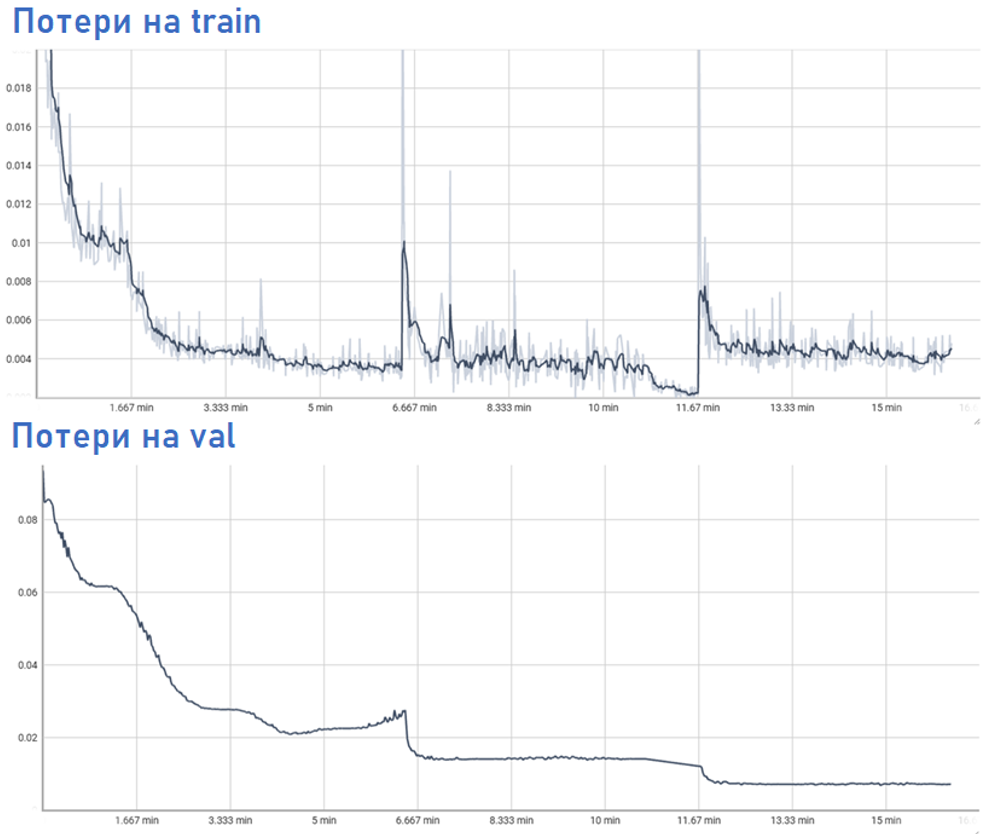

# 3. Тестирование модели

## Оценка качества модели на чистых, нормальных данных

## 3.1. Общая методология тестирования

Тестирование представляет собой процедуру оценки прогностической способности обученной модели на изолированных временных интервалах, предварительно очищенных от аномальных наблюдений. Данная методология позволяет объективно оценить качество прогнозирования в условиях, приближенных к нормальному режиму работы технологической системы.

## 3.2. Определение временных границ и параметров

Конфигурация тестирования определяется следующими параметрами:

- **Граница разделения**: `split_date = pd.Timestamp('2017-03-06')` — фиксированная временная точка, разделяющая данные на обучающую и тестовую выборки
- **Длина исторического контекста**: `input_chunk = 288` соответствует одной неделе наблюдений при 10-минутном интервале регистрации
- **Горизонт прогнозирования**: `output_chunk = 1` обеспечивает прогноз на один шаг вперед (10 минут)

## 3.3. Изоляция и очистка тестовых данных

Процедура подготовки тестовых данных включает:

- **Выделение тестового периода**: все наблюдения, зарегистрированные после `split_date`, формируют тестовый датасет
- **Буферизация аномальных зон**:
  - `buffer_before = 48*6` — удаление 48 часов данных, предшествующих аномалии
  - `buffer_after = 36` — исключение 6 часов данных после аномалии
- **Минимальный размер сегмента**: `min_segment = 288` — требование минимальной продолжительности (2 суток) для статистической значимости

Алгоритм очистки применяет расширенную маску к аномальным точкам, исключая не только непосредственные аномалии, но и окружающие временные интервалы, что позволяет минимизировать влияние переходных процессов и гарантировать оценку модели исключительно на данных, соответствующих нормальному режиму.

## 3.4. Сегментация чистых интервалов

После применения процедуры очистки формируются изолированные сегменты, соответствующие нормальному режиму работы оборудования. Для каждого сегмента проводится проверка соответствия минимальному требованию длины (≥288 точек). Сегменты, не удовлетворяющие данному критерию, исключаются из дальнейшего анализа.

## 3.5. Процедура прогнозирования

Для каждого валидного сегмента выполняется последовательная процедура:

- **Нормализация данных**: применение предварительно обученного объекта `Scaler` для консистентного масштабирования
- **Скользящее окно прогнозирования**: итеративное предсказание на один шаг вперед с использованием фиксированного исторического контекста
- **Сбор результатов**: формирование массивов фактических значений и соответствующих прогнозов модели

## 3.6. Вычисление метрик качества

Для количественной оценки точности прогнозирования вычисляются следующие метрики:

- **MAE (Mean Absolute Error)**: средняя абсолютная ошибка, характеризующая точность прогноза в абсолютных единицах измерения
- **R² (Коэффициент детерминации)**: доля дисперсии, объясненная моделью, отражающая общее качество аппроксимации

Метрики рассчитываются как для отдельных временных рядов (признаков), так и в агрегированном виде по всем признакам.

## 3.7. Сравнительный анализ и визуализация

Для комплексной интерпретации результатов тестирования реализованы следующие аналитические процедуры:

- **Ранжирование признаков**: идентификация топ-3 лучших и худших прогнозируемых признаков на основе значения R²
- **Временные графики**: визуальное сопоставление фактических и прогнозируемых значений с выделением доверительного интервала (±MAE)
- **Диаграммы рассеяния**: анализ взаимосвязи фактических и прогнозируемых значений с отображением линии идеального прогноза
- **Статистические распределения**: гистограммы абсолютных ошибок и значений R² по всем признакам
- **Боксплоты**: сравнительный анализ распределения ошибок прогнозирования для отдельных признаков

Данный комплексный подход обеспечивает всестороннюю оценку качества модели и выявление её сильных и слабых сторон при прогнозировании различных технологических параметров.

MAE выбрана как баланс между робастностью и интерпретируемостью в условиях, когда:

1. Распределение остатков может содержать выбросы (аномалии)

2. Необходима понятная связь между метрикой и порогами детектирования

3. Требуется сравнивать качество прогноза для разнородных сигналов

4. Важна устойчивость к ненормальности распределений

На реальных промышленных данных аномалии редко бывают одиночными точечными выбросами. Обычно это:

1. Дрейф параметров (постепенное изменение)

2. Ступенчатые изменения (сдвиг уровня)

3. Циклические нарушения (сбой в периодичности)

4. Комбинационные аномалии (нарушение корреляции между признаками)

Все эти типы аномалий создают продолжительные отклонения, которые надежно детектируются через превышение порога, основанного на MAE.

ТЕСТИРОВАНИЕ ТРАНСФОРМЕРА НА ЧИСТЫХ ДАННЫХ
Всего тестовых точек: 16148
Аномалий в тесте: 6
Процент аномалий: 0.04%

Найдено чистых сегментов: 5
  Сегмент 1: длина=3322 точек (23.1 дней)
  Сегмент 2: длина=609 точек (4.2 дней)
  Сегмент 3: длина=1815 точек (12.6 дней)
  Сегмент 4: длина=5865 точек (40.7 дней)
  Сегмент 5: длина=2267 точек (15.7 дней)

ТЕСТИРОВАНИЕ СЕГМЕНТА 1/5
Длина: 3322 точек


Прогнозирование:   2%|█▍                                                            | 47/2000 [00:00<00:04, 461.56it/s]


Ошибка на шаге 0: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 2: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 3: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 4: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 5: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 6: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 7: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 8: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 9: TorchForecastingMo

Прогнозирование:   5%|██▉                                                           | 94/2000 [00:00<00:04, 455.80it/s]


Ошибка на шаге 70: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 71: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 72: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 73: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 74: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 75: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 76: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 77: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 78: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 79: TorchFor

Прогнозирование:   7%|████▎                                                        | 142/2000 [00:00<00:03, 466.61it/s]


Ошибка на шаге 94: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 95: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 96: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 97: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 98: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 99: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 100: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 101: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 102: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 103: Torc

Прогнозирование:   9%|█████▊                                                       | 189/2000 [00:00<00:03, 464.03it/s]


Ошибка на шаге 162: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 163: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 164: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 165: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 166: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 167: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 168: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 169: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 170: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 171

Прогнозирование:  12%|███████▏                                                     | 236/2000 [00:00<00:03, 457.96it/s]


Ошибка на шаге 189: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 190: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 191: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 192: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 193: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 194: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 195: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 196: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 197: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 198

Прогнозирование:  14%|████████▋                                                    | 283/2000 [00:00<00:03, 461.94it/s]


Ошибка на шаге 258: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 259: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 260: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 261: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 262: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 263: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 264: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 265: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 266: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 267

Прогнозирование:  17%|██████████                                                   | 331/2000 [00:00<00:03, 467.73it/s]


Ошибка на шаге 283: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 284: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 285: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 286: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 287: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 288: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 289: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 290: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 291: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 292

Прогнозирование:  19%|███████████▌                                                 | 379/2000 [00:00<00:03, 471.56it/s]


Ошибка на шаге 357: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 358: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 359: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 360: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 361: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 362: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 363: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 364: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 365: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 366

Прогнозирование:  21%|█████████████                                                | 429/2000 [00:00<00:03, 478.87it/s]


Ошибка на шаге 379: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 380: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 381: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 382: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 383: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 384: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 385: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 386: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 387: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 388

Прогнозирование:  26%|████████████████                                             | 527/2000 [00:01<00:03, 484.02it/s]


Ошибка на шаге 474: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 475: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 476: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 477: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 478: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 479: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 480: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 481: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 482: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 483

Прогнозирование:  31%|███████████████████                                          | 625/2000 [00:01<00:02, 479.50it/s]


Ошибка на шаге 573: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 574: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 575: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 576: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 577: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 578: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 579: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 580: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 581: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 582

Прогнозирование:  34%|████████████████████▌                                        | 673/2000 [00:01<00:02, 479.61it/s]


Ошибка на шаге 658: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 659: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 660: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 661: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 662: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 663: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 664: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 665: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 666: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 667

Прогнозирование:  36%|█████████████████████▉                                       | 721/2000 [00:01<00:02, 471.21it/s]


Ошибка на шаге 673: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 674: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 675: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 676: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 677: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 678: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 679: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 680: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 681: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 682

Прогнозирование:  38%|███████████████████████▍                                     | 770/2000 [00:01<00:02, 476.72it/s]


Ошибка на шаге 770: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 771: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 772: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 773: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 774: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 775: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 776: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 777: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 778: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 779

Прогнозирование:  41%|████████████████████████▉                                    | 818/2000 [00:01<00:03, 379.66it/s]


Ошибка на шаге 814: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 815: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 816: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 817: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'


Прогнозирование:  43%|██████████████████████████▎                                  | 862/2000 [00:01<00:02, 394.84it/s]


Ошибка на шаге 818: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 819: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 820: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 821: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 822: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 823: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 824: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 825: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 826: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 827

Прогнозирование:  48%|█████████████████████████████▎                               | 961/2000 [00:02<00:02, 439.87it/s]


Ошибка на шаге 908: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 909: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 910: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 911: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 912: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 913: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 914: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 915: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 916: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 917

Прогнозирование:  53%|███████████████████████████████▋                            | 1056/2000 [00:02<00:02, 454.46it/s]


Ошибка на шаге 1006: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1007: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1008: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1009: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1010: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1011: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1012: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1013: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1014: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  60%|████████████████████████████████████▏                       | 1207/2000 [00:02<00:01, 484.04it/s]


Ошибка на шаге 1104: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1105: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1106: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1107: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1108: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1109: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1110: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1111: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1112: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  65%|███████████████████████████████████████▏                    | 1307/2000 [00:02<00:01, 490.44it/s]


Ошибка на шаге 1207: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1208: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1209: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1210: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1211: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1212: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1213: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1214: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1215: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  70%|██████████████████████████████████████████▏                 | 1407/2000 [00:03<00:01, 487.67it/s]


Ошибка на шаге 1307: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1308: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1309: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1310: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1311: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1312: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1313: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1314: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1315: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  75%|█████████████████████████████████████████████▏              | 1508/2000 [00:03<00:00, 492.87it/s]


Ошибка на шаге 1407: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1408: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1409: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1410: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1411: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1412: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1413: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1414: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1415: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  78%|██████████████████████████████████████████████▋             | 1558/2000 [00:03<00:00, 490.59it/s]


Ошибка на шаге 1508: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1509: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1510: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1511: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1512: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1513: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1514: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1515: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1516: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  83%|█████████████████████████████████████████████████▊          | 1660/2000 [00:03<00:00, 499.28it/s]


Ошибка на шаге 1606: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1607: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1608: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1609: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1610: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1611: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1612: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1613: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1614: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  88%|████████████████████████████████████████████████████▊       | 1761/2000 [00:03<00:00, 492.28it/s]


Ошибка на шаге 1710: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1711: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1712: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1713: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1714: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1715: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1716: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1717: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1718: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  96%|█████████████████████████████████████████████████████████▍  | 1916/2000 [00:04<00:00, 506.63it/s]


Ошибка на шаге 1813: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1814: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1815: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1816: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1817: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1818: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1819: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1820: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1821: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 473.94it/s]



Ошибка на шаге 1916: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1917: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1918: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1919: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1920: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1921: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1922: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1923: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1924: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

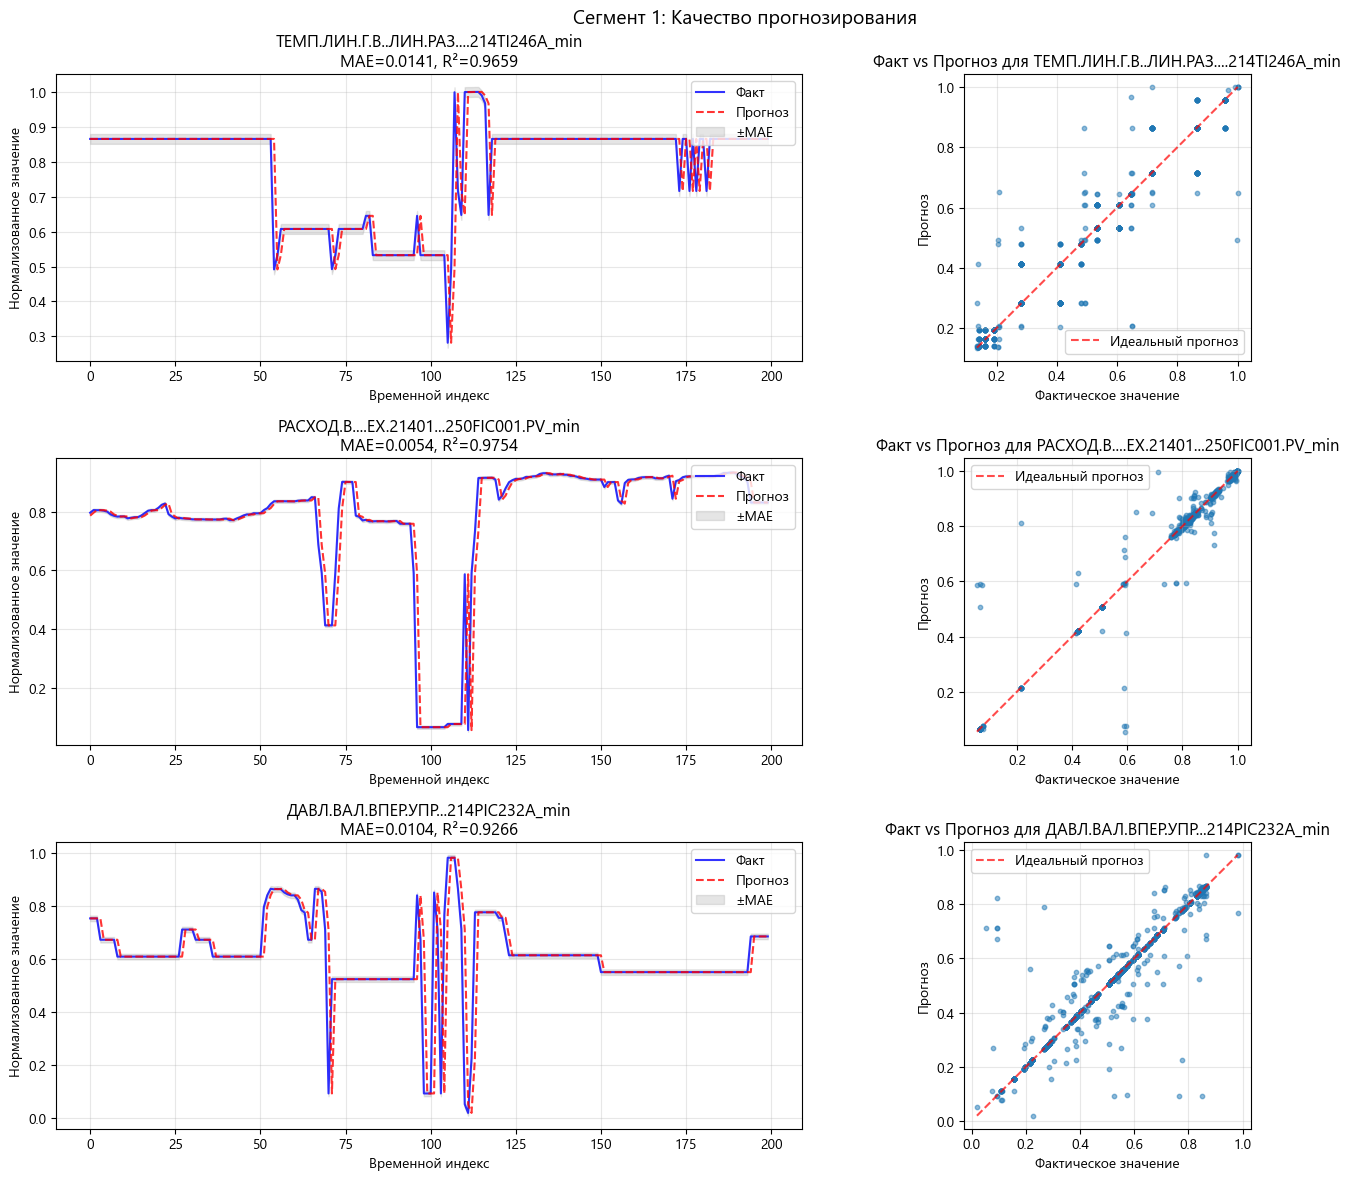

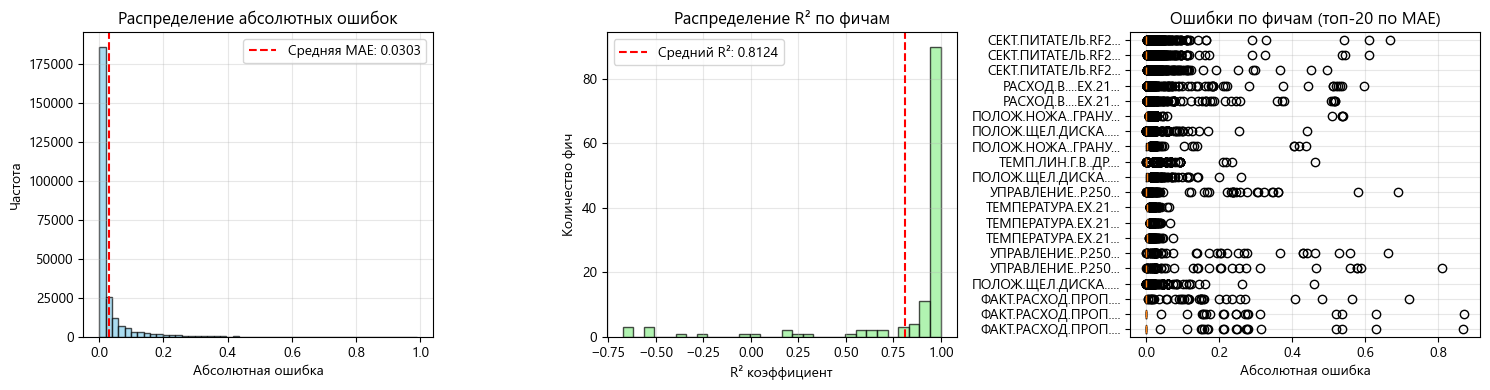


ТЕСТИРОВАНИЕ СЕГМЕНТА 2/5
Длина: 609 точек


Прогнозирование:  32%|████████████████████▏                                         | 104/320 [00:00<00:00, 516.83it/s]


Ошибка на шаге 0: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 2: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 3: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 4: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 5: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 6: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 7: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 8: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 9: TorchForecastingMo

Прогнозирование:  49%|██████████████████████████████▏                               | 156/320 [00:00<00:00, 511.23it/s]


Ошибка на шаге 104: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 105: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 106: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 107: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 108: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 109: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 110: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 111: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 112: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 113

Прогнозирование:  81%|█████████████████████████████████████████████████▉            | 258/320 [00:00<00:00, 494.62it/s]


Ошибка на шаге 200: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 201: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 202: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 203: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 204: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 205: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 206: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 207: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 208: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 209

Прогнозирование: 100%|██████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 495.23it/s]



Ошибка на шаге 308: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 309: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 310: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 311: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 312: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 313: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 314: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 315: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 316: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 317

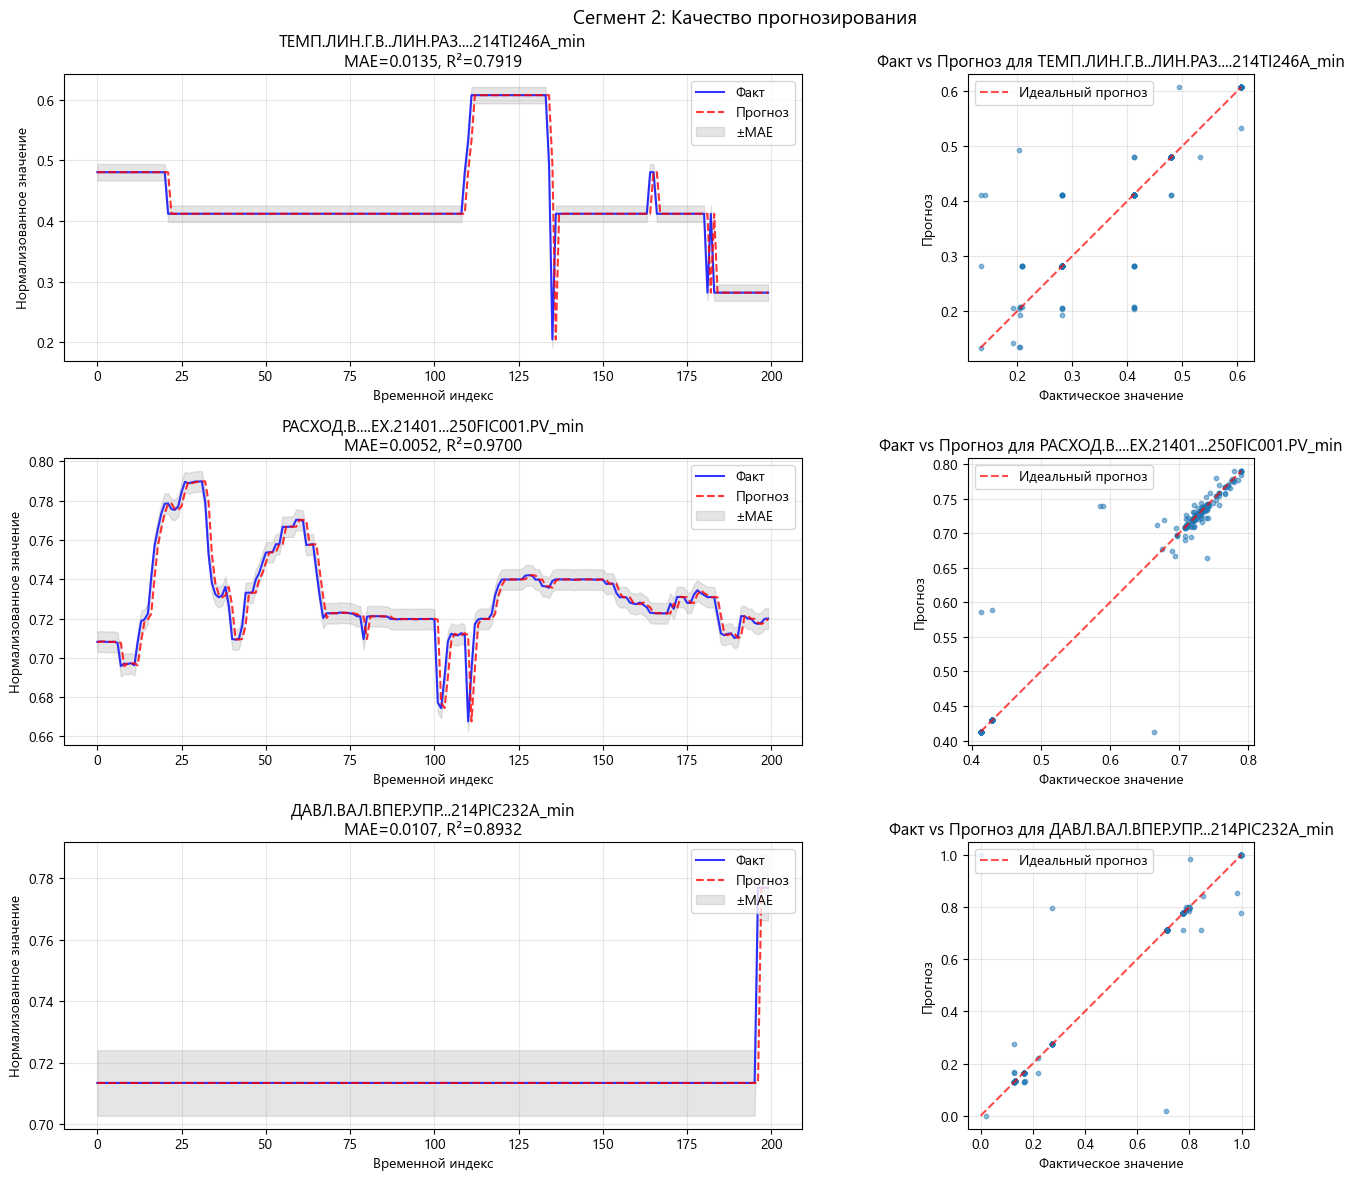

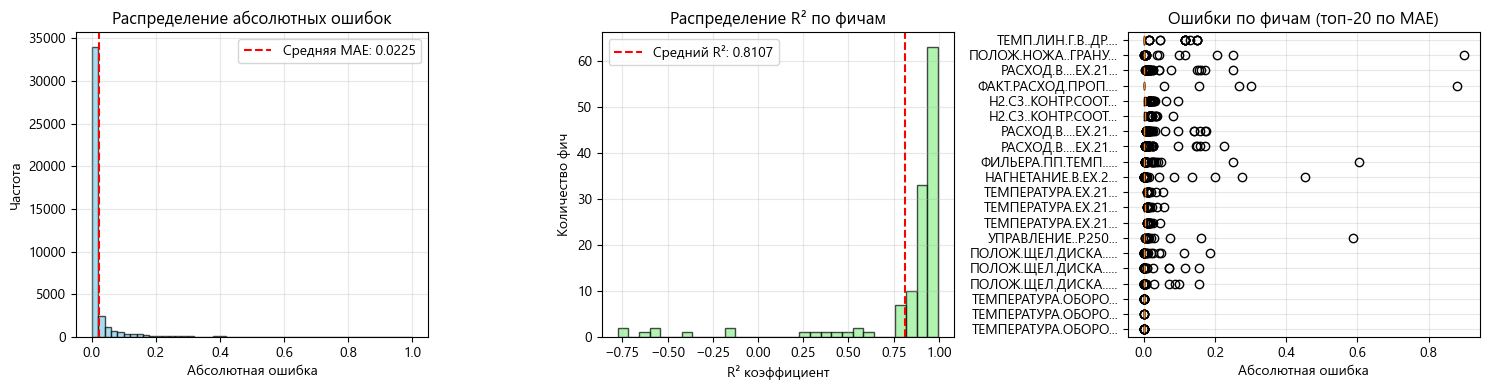


ТЕСТИРОВАНИЕ СЕГМЕНТА 3/5
Длина: 1815 точек


Прогнозирование:   3%|█▉                                                            | 48/1526 [00:00<00:03, 479.87it/s]


Ошибка на шаге 0: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 2: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 3: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 4: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 5: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 6: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 7: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 8: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 9: TorchForecastingMo

Прогнозирование:  10%|█████▉                                                       | 149/1526 [00:00<00:02, 498.74it/s]



Ошибка на шаге 93: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 94: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 95: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 96: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 97: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 98: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 99: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 100: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 101: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 102: Torc

Прогнозирование:  20%|███████████▉                                                 | 300/1526 [00:00<00:02, 491.04it/s]


Ошибка на шаге 192: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 193: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 194: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 195: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 196: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 197: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 198: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 199: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 200: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 201

Прогнозирование:  26%|████████████████                                             | 401/1526 [00:00<00:02, 496.86it/s]


Ошибка на шаге 300: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 301: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 302: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 303: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 304: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 305: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 306: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 307: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 308: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 309

Прогнозирование:  33%|████████████████████▏                                        | 504/1526 [00:01<00:02, 499.58it/s]


Ошибка на шаге 401: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 402: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 403: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 404: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 405: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 406: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 407: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 408: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 409: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 410

Прогнозирование:  36%|██████████████████████▏                                      | 554/1526 [00:01<00:01, 493.69it/s]


Ошибка на шаге 504: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 505: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 506: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 507: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 508: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 509: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 510: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 511: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 512: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 513

Прогнозирование:  43%|██████████████████████████                                   | 653/1526 [00:01<00:01, 487.72it/s]


Ошибка на шаге 598: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 599: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 600: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 601: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 602: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 603: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 604: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 605: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 606: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 607

Прогнозирование:  49%|██████████████████████████████▏                              | 755/1526 [00:01<00:01, 498.34it/s]


Ошибка на шаге 700: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 701: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 702: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 703: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 704: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 705: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 706: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 707: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 708: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 709

Прогнозирование:  56%|██████████████████████████████████▎                          | 858/1526 [00:01<00:01, 503.10it/s]


Ошибка на шаге 806: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 807: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 808: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 809: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 810: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 811: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 812: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 813: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 814: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 815

Прогнозирование:  63%|██████████████████████████████████████▍                      | 961/1526 [00:01<00:01, 498.66it/s]


Ошибка на шаге 910: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 911: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 912: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 913: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 914: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 915: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 916: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 917: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 918: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 919

Прогнозирование:  73%|███████████████████████████████████████████▊                | 1113/1526 [00:02<00:00, 501.56it/s]


Ошибка на шаге 1010: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1011: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1012: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1013: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1014: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1015: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1016: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1017: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1018: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  80%|███████████████████████████████████████████████▊            | 1216/1526 [00:02<00:00, 503.69it/s]


Ошибка на шаге 1113: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1114: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1115: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1116: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1117: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1118: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1119: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1120: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1121: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  83%|█████████████████████████████████████████████████▊          | 1267/1526 [00:02<00:00, 505.52it/s]


Ошибка на шаге 1216: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1217: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1218: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1219: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1220: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1221: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1222: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1223: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1224: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  90%|█████████████████████████████████████████████████████▊      | 1370/1526 [00:02<00:00, 503.28it/s]


Ошибка на шаге 1313: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1314: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1315: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1316: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1317: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1318: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1319: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1320: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1321: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  96%|█████████████████████████████████████████████████████████▉  | 1472/1526 [00:02<00:00, 501.40it/s]


Ошибка на шаге 1416: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1417: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1418: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1419: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1420: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1421: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1422: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1423: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1424: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование: 100%|████████████████████████████████████████████████████████████| 1526/1526 [00:03<00:00, 496.31it/s]



Ошибка на шаге 1516: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1517: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1518: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1519: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1520: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1521: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1522: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1523: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1524: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

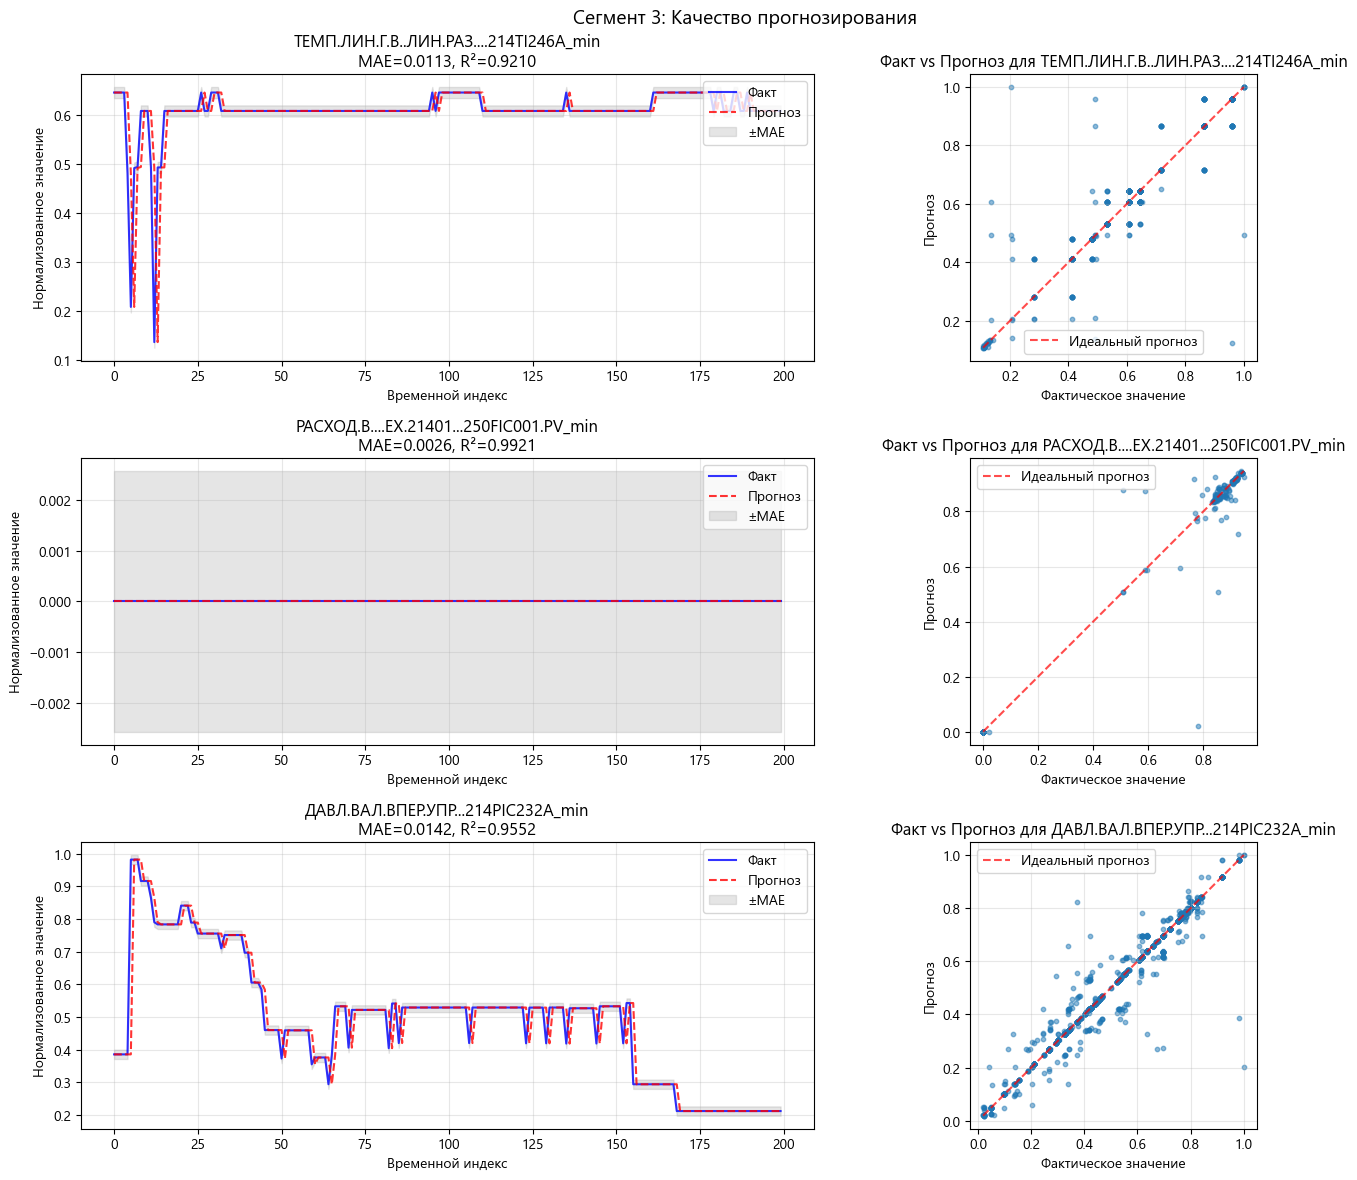

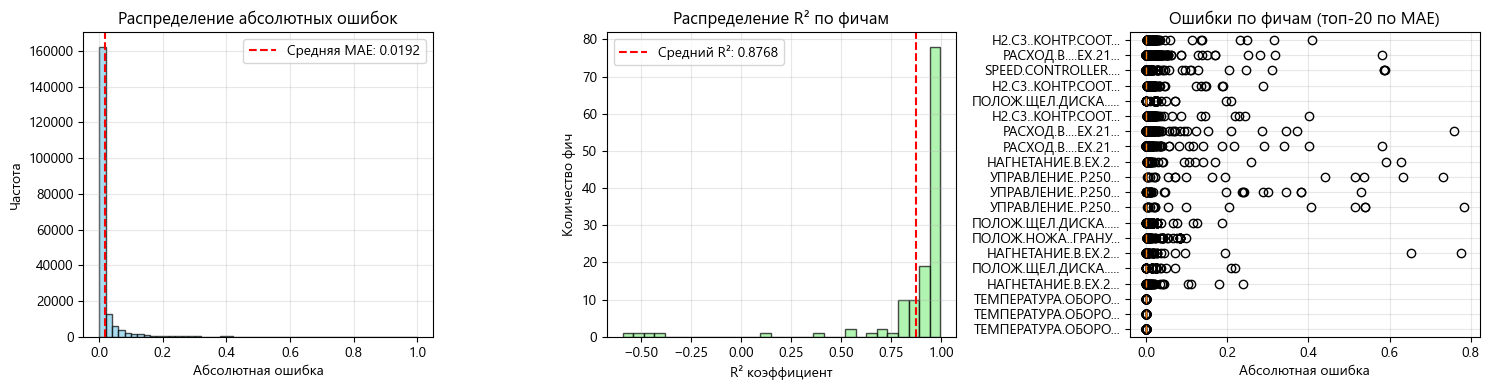


ТЕСТИРОВАНИЕ СЕГМЕНТА 4/5
Длина: 5865 точек


Прогнозирование:   3%|█▌                                                            | 51/2000 [00:00<00:03, 504.12it/s]


Ошибка на шаге 0: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 2: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 3: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 4: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 5: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 6: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 7: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 8: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 9: TorchForecastingMo

Прогнозирование:   5%|███                                                          | 102/2000 [00:00<00:03, 498.73it/s]


Ошибка на шаге 71: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 72: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 73: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 74: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 75: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 76: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 77: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 78: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 79: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 80: TorchFor

Прогнозирование:   8%|████▋                                                        | 153/2000 [00:00<00:03, 501.49it/s]


Ошибка на шаге 102: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 103: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 104: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 105: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 106: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 107: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 108: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 109: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 110: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 111

Прогнозирование:  10%|██████▏                                                      | 204/2000 [00:00<00:03, 495.35it/s]


Ошибка на шаге 181: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 182: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 183: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 184: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 185: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 186: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 187: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 188: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 189: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 190

Прогнозирование:  13%|███████▊                                                     | 255/2000 [00:00<00:03, 497.05it/s]


Ошибка на шаге 204: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 205: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 206: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 207: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 208: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 209: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 210: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 211: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 212: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 213

Прогнозирование:  15%|█████████▎                                                   | 305/2000 [00:00<00:03, 486.61it/s]


Ошибка на шаге 281: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 282: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 283: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 284: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 285: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 286: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 287: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 288: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 289: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 290

Прогнозирование:  18%|██████████▊                                                  | 355/2000 [00:00<00:03, 489.28it/s]


Ошибка на шаге 305: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 306: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 307: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 308: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 309: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 310: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 311: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 312: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 313: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 314

Прогнозирование:  20%|████████████▎                                                | 404/2000 [00:00<00:03, 484.93it/s]


Ошибка на шаге 381: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 382: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 383: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 384: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 385: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 386: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 387: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 388: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 389: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 390

Прогнозирование:  23%|█████████████▊                                               | 454/2000 [00:00<00:03, 489.51it/s]


Ошибка на шаге 404: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 405: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 406: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 407: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 408: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 409: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 410: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 411: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 412: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 413

Прогнозирование:  25%|███████████████▎                                             | 503/2000 [00:01<00:03, 489.61it/s]


Ошибка на шаге 491: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 492: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 493: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 494: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 495: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 496: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 497: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 498: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 499: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 500

Прогнозирование:  28%|████████████████▊                                            | 553/2000 [00:01<00:02, 492.70it/s]


Ошибка на шаге 503: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 504: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 505: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 506: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 507: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 508: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 509: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 510: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 511: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 512

Прогнозирование:  33%|████████████████████                                         | 656/2000 [00:01<00:02, 502.98it/s]


Ошибка на шаге 594: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 595: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 596: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 597: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 598: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 599: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 600: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 601: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 602: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 603

Прогнозирование:  38%|███████████████████████                                      | 758/2000 [00:01<00:02, 499.19it/s]


Ошибка на шаге 699: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 700: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 701: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 702: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 703: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 704: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 705: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 706: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 707: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 708

Прогнозирование:  43%|██████████████████████████▎                                  | 861/2000 [00:01<00:02, 488.36it/s]


Ошибка на шаге 801: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 802: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 803: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 804: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 805: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 806: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 807: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 808: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 809: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 810

Прогнозирование:  48%|█████████████████████████████▎                               | 961/2000 [00:01<00:02, 486.94it/s]


Ошибка на шаге 901: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 902: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 903: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 904: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 905: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 906: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 907: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 908: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 909: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 910

Прогнозирование:  56%|█████████████████████████████████▎                          | 1112/2000 [00:02<00:01, 498.47it/s]


Ошибка на шаге 1000: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1001: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1002: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1003: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1004: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1005: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1006: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1007: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1008: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  61%|████████████████████████████████████▍                       | 1215/2000 [00:02<00:01, 505.80it/s]


Ошибка на шаге 1112: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1113: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1114: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1115: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1116: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1117: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1118: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1119: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1120: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  63%|█████████████████████████████████████▉                      | 1266/2000 [00:02<00:01, 505.76it/s]


Ошибка на шаге 1215: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1216: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1217: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1218: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1219: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1220: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1221: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1222: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1223: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  71%|██████████████████████████████████████████▌                 | 1419/2000 [00:02<00:01, 499.18it/s]


Ошибка на шаге 1313: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1314: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1315: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1316: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1317: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1318: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1319: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1320: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1321: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  76%|█████████████████████████████████████████████▌              | 1520/2000 [00:03<00:00, 493.28it/s]


Ошибка на шаге 1419: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1420: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1421: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1422: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1423: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1424: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1425: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1426: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1427: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  79%|███████████████████████████████████████████████▏            | 1571/2000 [00:03<00:00, 496.69it/s]


Ошибка на шаге 1520: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1521: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1522: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1523: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1524: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1525: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1526: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1527: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1528: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  84%|██████████████████████████████████████████████████▏         | 1673/2000 [00:03<00:00, 500.66it/s]


Ошибка на шаге 1618: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1619: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1620: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1621: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1622: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1623: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1624: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1625: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1626: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  89%|█████████████████████████████████████████████████████▎      | 1775/2000 [00:03<00:00, 492.56it/s]


Ошибка на шаге 1723: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1724: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1725: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1726: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1727: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1728: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1729: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1730: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1731: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  96%|█████████████████████████████████████████████████████████▊  | 1928/2000 [00:03<00:00, 502.02it/s]


Ошибка на шаге 1824: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1825: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1826: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1827: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1828: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1829: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1830: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1831: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1832: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 496.66it/s]



Ошибка на шаге 1928: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1929: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1930: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1931: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1932: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1933: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1934: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1935: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1936: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

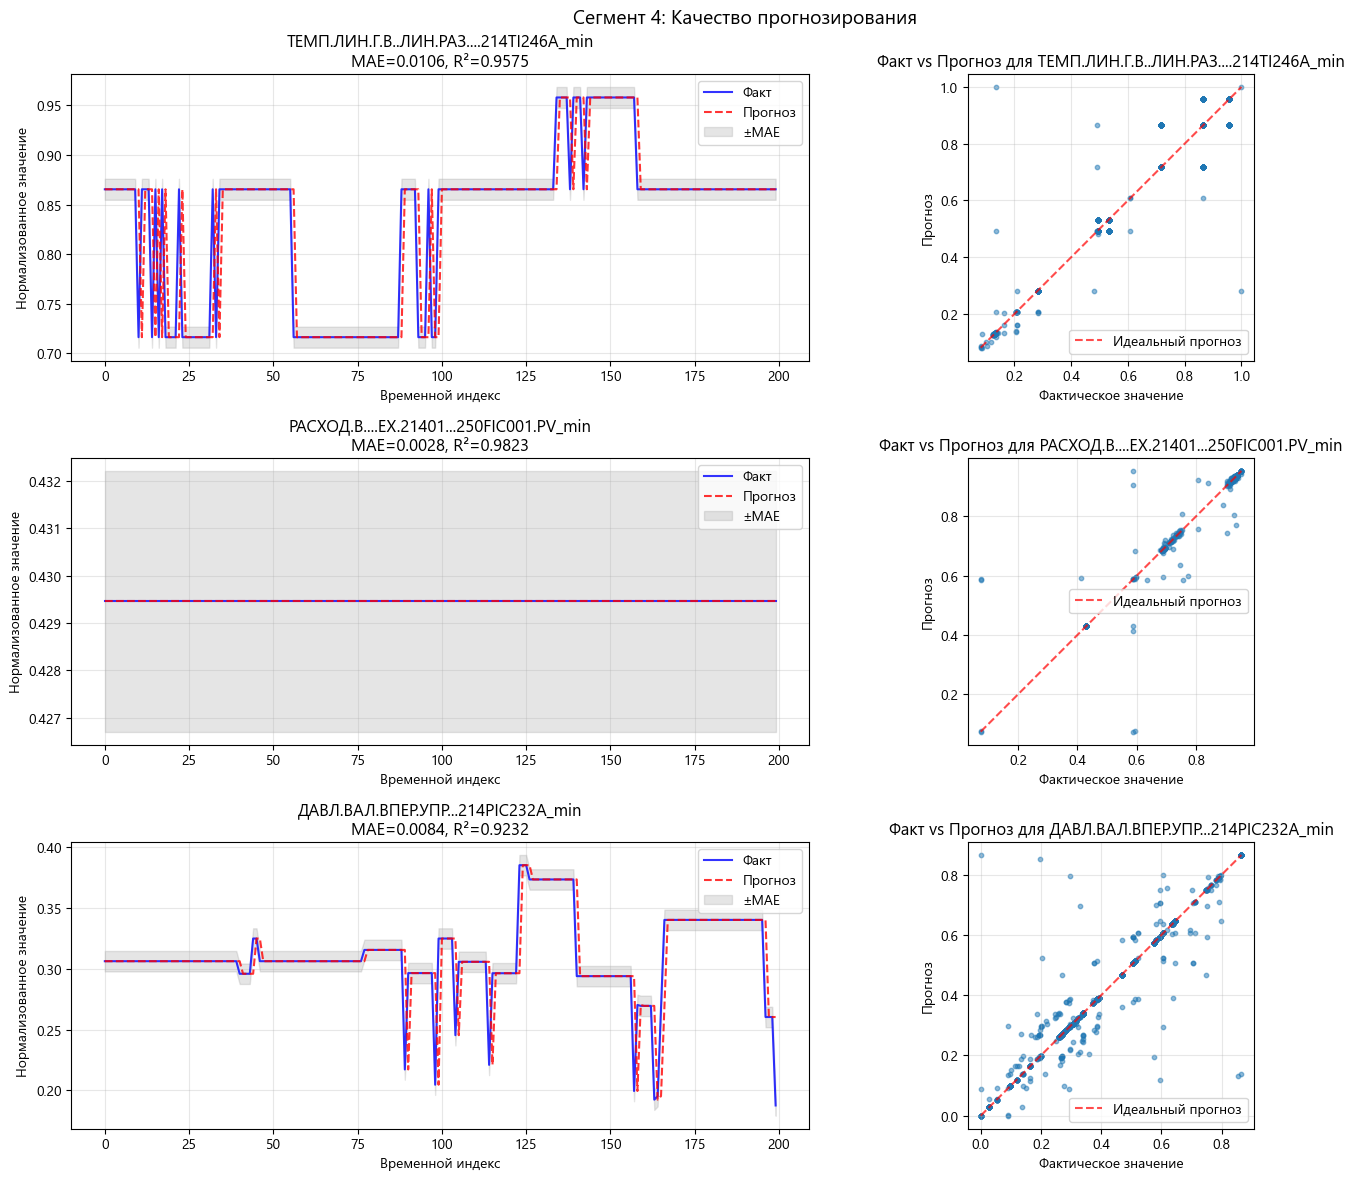

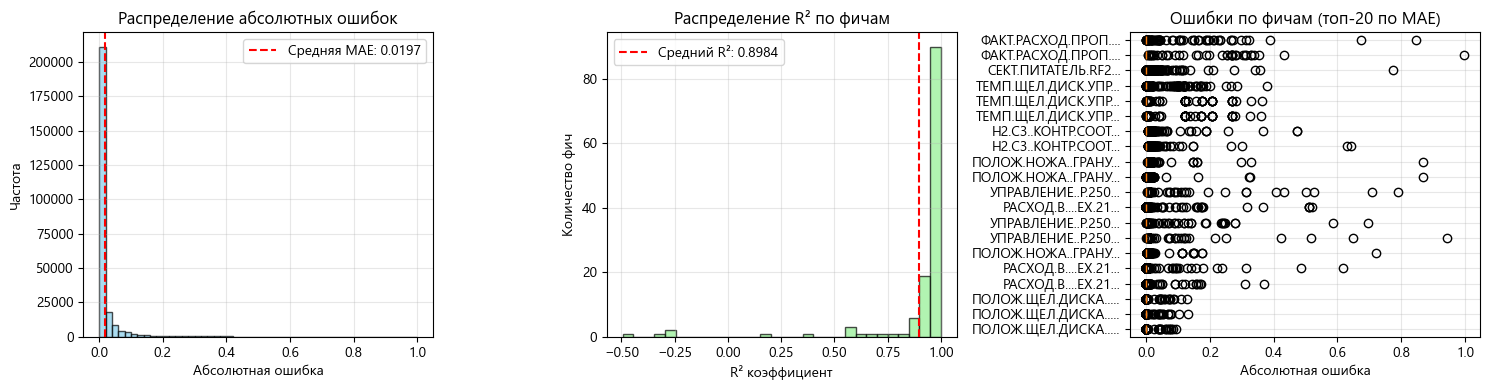


ТЕСТИРОВАНИЕ СЕГМЕНТА 5/5
Длина: 2267 точек


Прогнозирование:   2%|█▌                                                            | 49/1978 [00:00<00:03, 489.88it/s]


Ошибка на шаге 0: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 2: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 3: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 4: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 5: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 6: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 7: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 8: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 9: TorchForecastingMo

Прогнозирование:  10%|██████▏                                                      | 200/1978 [00:00<00:03, 500.60it/s]


Ошибка на шаге 89: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 90: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 91: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 92: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 93: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 94: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 95: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 96: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 97: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 98: TorchFor

Прогнозирование:  15%|█████████▎                                                   | 302/1978 [00:00<00:03, 502.10it/s]


Ошибка на шаге 200: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 201: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 202: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 203: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 204: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 205: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 206: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 207: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 208: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 209

Прогнозирование:  18%|██████████▉                                                  | 353/1978 [00:00<00:04, 389.52it/s]


Ошибка на шаге 302: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 303: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 304: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 305: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 306: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 307: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 308: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 309: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 310: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 311

Прогнозирование:  23%|█████████████▊                                               | 446/1978 [00:01<00:03, 412.35it/s]


Ошибка на шаге 353: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 354: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 355: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 356: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 357: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 358: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 359: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 360: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 361: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 362

Прогнозирование:  27%|████████████████▋                                            | 543/1978 [00:01<00:03, 444.45it/s]


Ошибка на шаге 446: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 447: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 448: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 449: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 450: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 451: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 452: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 453: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 454: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 455

Прогнозирование:  33%|███████████████████▉                                         | 646/1978 [00:01<00:02, 477.54it/s]


Ошибка на шаге 543: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 544: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 545: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 546: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 547: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 548: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 549: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 550: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 551: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 552

Прогнозирование:  35%|█████████████████████▍                                       | 697/1978 [00:01<00:02, 485.57it/s]


Ошибка на шаге 646: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 647: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 648: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 649: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 650: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 651: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 652: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 653: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 654: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 655

Прогнозирование:  40%|████████████████████████▌                                    | 797/1978 [00:01<00:02, 487.72it/s]


Ошибка на шаге 744: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 745: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 746: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 747: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 748: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 749: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 750: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 751: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 752: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 753

Прогнозирование:  48%|█████████████████████████████▎                               | 950/1978 [00:02<00:02, 496.68it/s]


Ошибка на шаге 844: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 845: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 846: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 847: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 848: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 849: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 850: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 851: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 852: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 853

Прогнозирование:  53%|███████████████████████████████▉                            | 1051/1978 [00:02<00:01, 493.64it/s]


Ошибка на шаге 950: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 951: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 952: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 953: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 954: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 955: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 956: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 957: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 958: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 959

Прогнозирование:  56%|█████████████████████████████████▍                          | 1101/1978 [00:02<00:01, 486.87it/s]


Ошибка на шаге 1051: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1052: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1053: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1054: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1055: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1056: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1057: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1058: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1059: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  61%|████████████████████████████████████▎                       | 1199/1978 [00:02<00:01, 470.22it/s]


Ошибка на шаге 1149: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1150: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1151: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1152: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1153: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1154: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1155: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1156: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1157: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  65%|███████████████████████████████████████▎                    | 1294/1978 [00:02<00:01, 465.42it/s]


Ошибка на шаге 1233: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1234: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1235: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1236: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1237: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1238: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1239: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1240: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1241: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  70%|██████████████████████████████████████████▎                 | 1394/1978 [00:02<00:01, 480.23it/s]


Ошибка на шаге 1333: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1334: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1335: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1336: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1337: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1338: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1339: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1340: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1341: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  76%|█████████████████████████████████████████████▎              | 1495/1978 [00:03<00:00, 491.33it/s]


Ошибка на шаге 1436: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1437: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1438: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1439: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1440: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1441: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1442: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1443: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1444: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  83%|█████████████████████████████████████████████████▉          | 1646/1978 [00:03<00:00, 490.08it/s]


Ошибка на шаге 1539: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1540: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1541: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1542: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1543: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1544: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1545: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1546: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1547: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  88%|████████████████████████████████████████████████████▉       | 1745/1978 [00:03<00:00, 483.30it/s]


Ошибка на шаге 1646: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1647: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1648: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1649: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1650: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1651: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1652: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1653: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1654: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  93%|████████████████████████████████████████████████████████    | 1847/1978 [00:03<00:00, 495.03it/s]


Ошибка на шаге 1745: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1746: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1747: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1748: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1749: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1750: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1751: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1752: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1753: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование:  98%|███████████████████████████████████████████████████████████ | 1947/1978 [00:04<00:00, 486.29it/s]


Ошибка на шаге 1847: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1848: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1849: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1850: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1851: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1852: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1853: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1854: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1855: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

Прогнозирование: 100%|████████████████████████████████████████████████████████████| 1978/1978 [00:04<00:00, 475.87it/s]



Ошибка на шаге 1947: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1948: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1949: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1950: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1951: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1952: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1953: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1954: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на шаге 1955: TorchForecastingModel.predict() got an unexpected keyword argument 'num_loader_workers'

Ошибка на

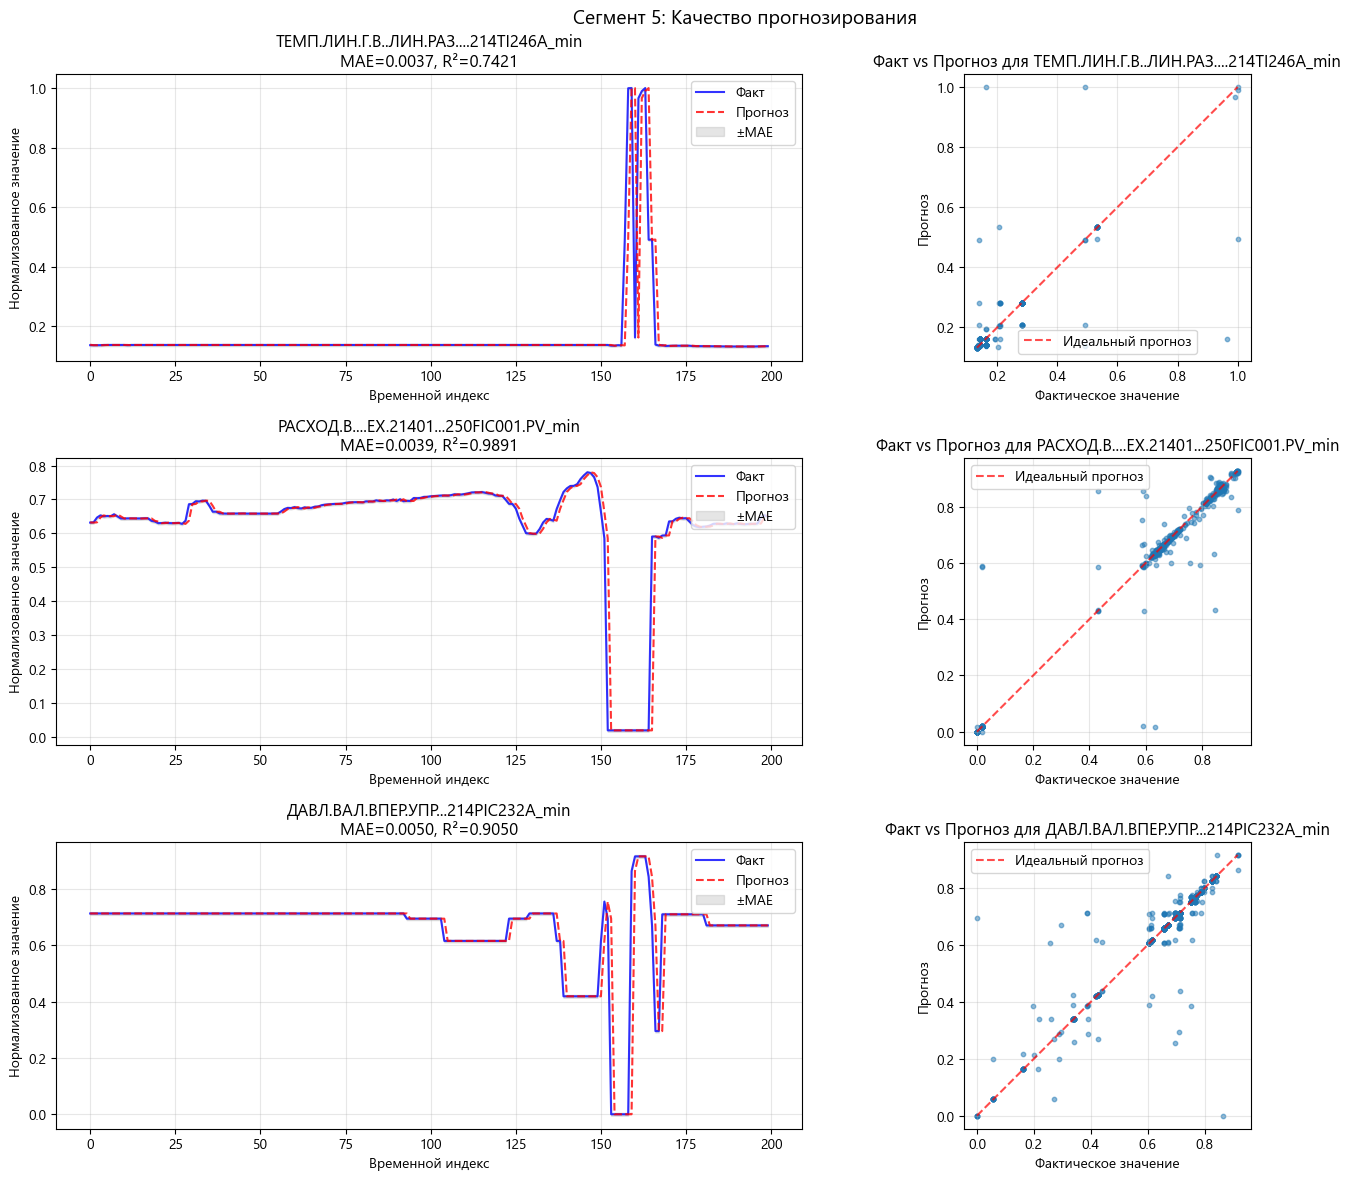

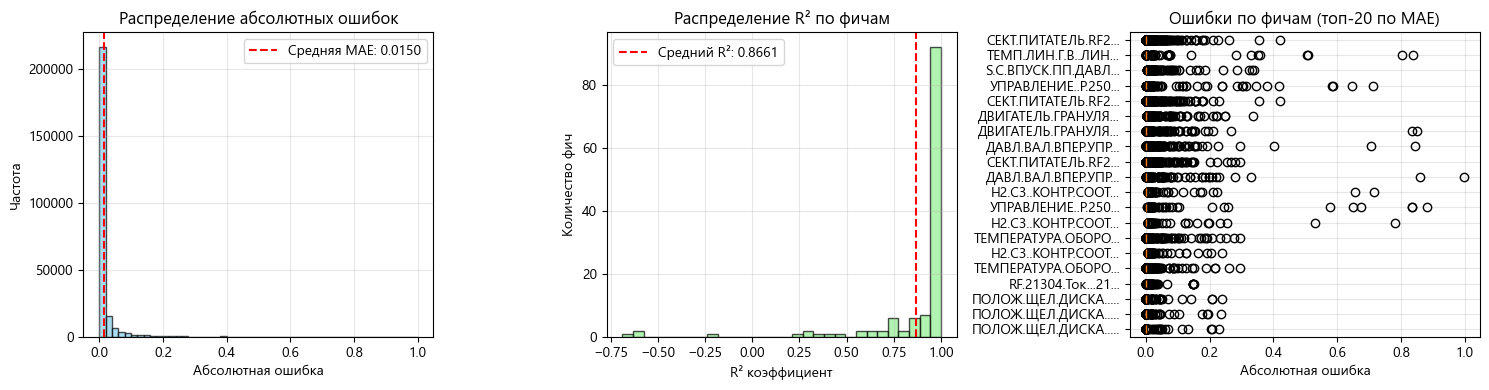


ИТОГОВЫЕ РЕЗУЛЬТАТЫ ПО ВСЕМ СЕГМЕНТАМ
Количество протестированных сегментов: 5
Средний MAE по всем сегментам: 0.021319 (±0.005096)
Средний R² по всем сегментам: 0.852902 (±0.035326)
Лучший R²: 0.898418
Худший R²: 0.810669


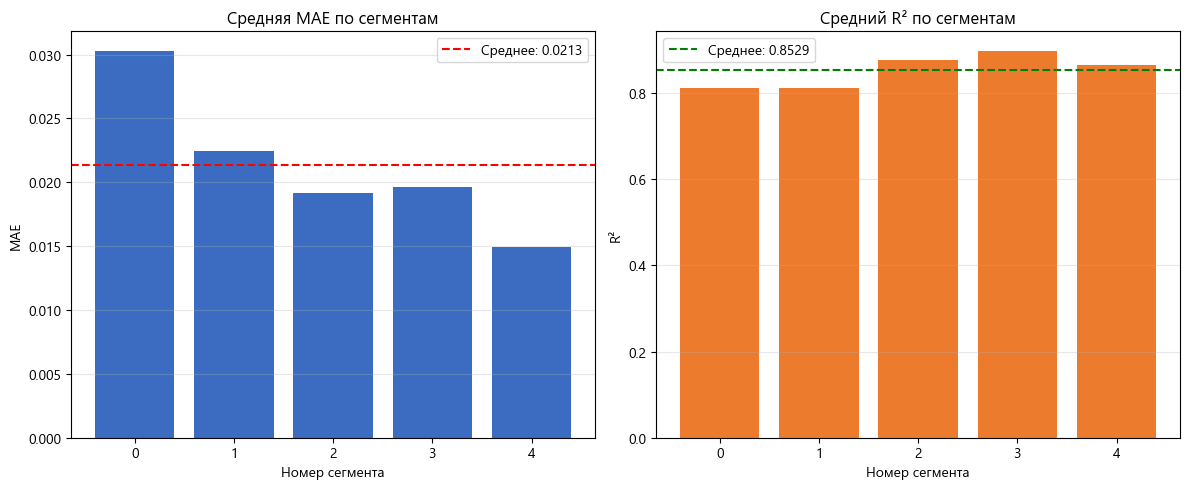


АНАЛИЗ ВАЖНОСТИ ФИЧ

Топ-10 лучших прогнозируемых фич:
 1. ТЕМПЕРАТУРА.EX.21401...250TI004_mean R²=0.9972, MAE=0.0042
 2. ТЕМПЕРАТУРА.EX.21401...250TI004_min R²=0.9970, MAE=0.0043
 3. ТЕМПЕРАТУРА.EX.21401...250TI004_max R²=0.9969, MAE=0.0043
 4. ПОЛОЖ.ЩЕЛ.ДИСКА...214ZI202A_mean R²=0.9967, MAE=0.0019
 5. ПОЛОЖ.ЩЕЛ.ДИСКА...214ZI202A_max R²=0.9966, MAE=0.0015
 6. ПОЛОЖ.ЩЕЛ.ДИСКА...214ZI202A_min R²=0.9961, MAE=0.0022
 7. ЦИЛ..8.ТЕМП.УПР...214TIC212A_max R²=0.9880, MAE=0.0124
 8. ЦИЛ..8.ТЕМП.УПР...214TIC212A_min R²=0.9879, MAE=0.0126
 9. ЦИЛ..9.ТЕМП.УПР...214TIC213A_max R²=0.9863, MAE=0.0102
10. ЦИЛ..7.ТЕМП.УПР...214TIC211A_max R²=0.9863, MAE=0.0126

Топ-10 худших прогнозируемых фич:
 1. РАСХОД.ЛИНИИ.P.W...214FI205A_min R²=-0.5025, MAE=0.1771
 2. РАСХОД.ЛИНИИ.P.W...214FI205A_max R²=-0.4904, MAE=0.1876
 3. RF.21304.Ток...213MII904A_max  R²=-0.4760, MAE=0.1120
 4. RF.21304.Ток...213MII904A_min  R²=-0.3453, MAE=0.0875
 5. ТЕМПЕРАТУРА.ОБОРОТН.ВОДЫ...250TIC003.PV_max R²=0.1536, MAE=0.0268
 6. Т

In [ ]:
# дата разделения данных (слева остаются данные для обучения, справа для теста)
split_date = pd.Timestamp('2017-03-06')

# даем модели недельный контекст
input_chunk = 288

# получаем прогноз на 1 день
output_chunk = 1

# вырезаемые точки вокруг аномалий (для очистки левой половины ВР для обучения на нормальный данных)
buffer_before = 48 * 6
buffer_after = 36
min_segment = 288

# Подготовка тестовых данных
test_df = df[df.index >= split_date].copy()
test_target = test_df[target_col].values.astype(int)


print("Тестирование модели на чистых данных")

print(f"Всего тестовых точек: {len(test_target)}")
print(f"Аномалий в тесте: {test_target.sum()}")
print(f"Процент аномалий: {test_target.sum()/len(test_target)*100:.2f}%")

# Очистка тестовых данных (удаляем аномалии с буфером)
mask = np.zeros(len(test_target), dtype=bool)
i = 0
while i < len(test_target):
    if test_target[i] == 1:
        j = i
        while j < len(test_target) and test_target[j] == 1:
            j += 1
        s = max(0, i - buffer_before)
        e = min(len(test_target), j + buffer_after)
        mask[s:e] = True
        i = j
    else:
        i += 1

# Находим чистые сегменты
clean_segments = []
cur = None
for idx in range(len(mask)):
    if not mask[idx]:
        if cur is None:
            cur = idx
    else:
        if cur is not None:
            L = idx - cur
            if L >= min_segment:
                seg_df = test_df.iloc[cur:idx]
                clean_segments.append({
                    'data': seg_df,
                    'start_idx': cur,
                    'length': L
                })
            cur = None

if cur is not None and (len(mask) - cur) >= min_segment:
    clean_segments.append({
        'data': test_df.iloc[cur:],
        'start_idx': cur,
        'length': len(mask) - cur
    })

if not clean_segments:
    print("Нет чистых сегментов в тестовых данных")
    exit()

print(f"\nНайдено чистых сегментов: {len(clean_segments)}")
for i, seg in enumerate(clean_segments):
    print(f"  Сегмент {i+1}: длина={seg['length']} точек ({seg['length']/144:.1f} дней)")

# Выбираем сегмент для тестирования
all_metrics = []

for seg_idx, seg in enumerate(clean_segments):

    print(f"Тестирование {seg_idx+1}/{len(clean_segments)}")
    print(f"Длина: {seg['length']} точек")


    test_segment = seg['data']

    # Подготовка временных рядов
    ts = TimeSeries.from_dataframe(
        test_segment[feature_cols],
        freq='10Min'
    ).astype(np.float32)

    cov = TimeSeries.from_dataframe(
        test_segment[covariate_cols],
        freq='10Min'
    ).astype(np.float32) if len(covariate_cols) > 0 else None

    scaled = scaler.transform(ts).astype(np.float32)

    # Прогнозирование с прогресс-баром
    n_predictions = len(scaled) - input_chunk - 1
    # Ограничиваем для скорости, но лучше прогнозировать весь сегмент
    max_predictions = min(2000, n_predictions)  # Можно увеличить

    actual_values_all = []  # Для всех фич
    predicted_values_all = []

    # Для визуализации выберем 3 случайные фичи
    np.random.seed(42)
    vis_features = np.random.choice(len(feature_cols), min(3, len(feature_cols)), replace=False)

    for i in tqdm(range(max_predictions), desc="Прогнозирование"):
        hist = scaled[i:i+input_chunk]
        hist_cov = cov[i:i+input_chunk+1] if cov is not None else None

        try:
            forecast = model.predict(
                n=1,
                series=hist,
                past_covariates=hist_cov,
                show_warnings=False,
                verbose=False,
                num_loader_workers=0  # Для избежания проблем с multiprocessing
            )

            actual = scaled[i+input_chunk:i+input_chunk+1]

            # Сохраняем все фичи
            actual_values_all.append(actual.values()[0])
            predicted_values_all.append(forecast.values()[0])

        except Exception as e:
            print(f"\nОшибка на шаге {i}: {e}")
            # Пропускаем или используем последнее значение
            actual_values_all.append(scaled[i+input_chunk].values()[0])
            predicted_values_all.append(scaled[i+input_chunk-1].values()[0])

    # Преобразуем в numpy массивы
    actual_values_all = np.array(actual_values_all)
    predicted_values_all = np.array(predicted_values_all)

    # Вычисляем метрики для каждой фичи
    print(f"Метрики для сегмента {seg_idx+1}")


    # Метрики для каждой фичи
    mae_per_feature = mean_absolute_error(actual_values_all, predicted_values_all, multioutput='raw_values')
    mse_per_feature = mean_squared_error(actual_values_all, predicted_values_all, multioutput='raw_values')
    rmse_per_feature = np.sqrt(mse_per_feature)

    # R^2 для каждой фичи
    r2_per_feature = []
    for i in range(actual_values_all.shape[1]):
        r2_i = r2_score(actual_values_all[:, i], predicted_values_all[:, i])
        r2_per_feature.append(r2_i)
    r2_per_feature = np.array(r2_per_feature)

    # Усредненные метрики
    mae_avg = mae_per_feature.mean()
    rmse_avg = rmse_per_feature.mean()
    r2_avg = r2_per_feature.mean()

    print(f"Усредненные метрики по всем {len(feature_cols)} фичам:")
    print(f"  MAE:  {mae_avg:.6f}")
    print(f"  RMSE: {rmse_avg:.6f}")
    print(f"  R²:   {r2_avg:.6f}")

    # Топ-3 лучших и худших фич по R²
    top_indices = np.argsort(r2_per_feature)[-3:][::-1]
    bottom_indices = np.argsort(r2_per_feature)[:3]

    print(f"\nЛучшие фичи по R²:")
    for idx in top_indices:
        print(f"  {feature_cols[idx]}: R²={r2_per_feature[idx]:.4f}, MAE={mae_per_feature[idx]:.4f}")

    print(f"\nХудшие фичи по R²:")
    for idx in bottom_indices:
        print(f"  {feature_cols[idx]}: R²={r2_per_feature[idx]:.4f}, MAE={mae_per_feature[idx]:.4f}")

    # Сохраняем метрики
    all_metrics.append({
        'segment_idx': seg_idx,
        'length': seg['length'],
        'mae_avg': mae_avg,
        'rmse_avg': rmse_avg,
        'r2_avg': r2_avg,
        'mae_per_feature': mae_per_feature,
        'r2_per_feature': r2_per_feature,
        'actual': actual_values_all,
        'predicted': predicted_values_all
    })

    # Визуализация для нескольких фич
    fig, axes = plt.subplots(len(vis_features), 2, figsize=(15, 4*len(vis_features)))

    if len(vis_features) == 1:
        axes = np.array([axes])

    for idx, feat_idx in enumerate(vis_features):
        feat_name = feature_cols[feat_idx]

        # График временного ряда
        ax1 = axes[idx, 0] if len(vis_features) > 1 else axes[0]
        n_plot = min(200, len(actual_values_all))

        ax1.plot(actual_values_all[:n_plot, feat_idx], 'b-',
                label='Факт', linewidth=1.5, alpha=0.8)
        ax1.plot(predicted_values_all[:n_plot, feat_idx], 'r--',
                label='Прогноз', linewidth=1.5, alpha=0.8)

        # Область ошибки ±MAE
        mae_val = mae_per_feature[feat_idx]
        ax1.fill_between(range(n_plot),
                        actual_values_all[:n_plot, feat_idx] - mae_val,
                        actual_values_all[:n_plot, feat_idx] + mae_val,
                        alpha=0.2, color='gray', label=f'±MAE')

        ax1.set_xlabel('Временной индекс')
        ax1.set_ylabel('Нормализованное значение')
        ax1.set_title(f'{feat_name}\nMAE={mae_val:.4f}, R²={r2_per_feature[feat_idx]:.4f}')
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)

        # Scatter plot факт vs прогноз
        ax2 = axes[idx, 1] if len(vis_features) > 1 else axes[1]
        ax2.scatter(actual_values_all[:, feat_idx], predicted_values_all[:, feat_idx],
                   alpha=0.5, s=10)

        # Линия идеального прогноза
        min_val = min(actual_values_all[:, feat_idx].min(), predicted_values_all[:, feat_idx].min())
        max_val = max(actual_values_all[:, feat_idx].max(), predicted_values_all[:, feat_idx].max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Идеальный прогноз')

        ax2.set_xlabel('Фактическое значение')
        ax2.set_ylabel('Прогноз')
        ax2.set_title(f'Факт vs Прогноз для {feat_name}')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_aspect('equal', 'box')

    plt.suptitle(f'Сегмент {seg_idx+1}: Качество прогнозирования', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Гистограмма ошибок
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    errors = actual_values_all - predicted_values_all

    # Гистограмма абсолютных ошибок
    axes[0].hist(np.abs(errors).flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].axvline(x=mae_avg, color='red', linestyle='--', label=f'Средняя MAE: {mae_avg:.4f}')
    axes[0].set_xlabel('Абсолютная ошибка')
    axes[0].set_ylabel('Частота')
    axes[0].set_title('Распределение абсолютных ошибок')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Гистограмма R^2 по фичам
    axes[1].hist(r2_per_feature, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1].axvline(x=r2_avg, color='red', linestyle='--', label=f'Средний R²: {r2_avg:.4f}')
    axes[1].set_xlabel('R² коэффициент')
    axes[1].set_ylabel('Количество фич')
    axes[1].set_title('Распределение R² по фичам')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Boxplot ошибок по фичам
    n_features_to_plot = min(20, len(feature_cols))
    top_indices_for_box = np.argsort(mae_per_feature)[:n_features_to_plot]

    box_data = []
    box_labels = []
    for i in top_indices_for_box:
        box_data.append(np.abs(errors[:, i]))
        # Укорачиваем длинные названия фич
        label = feature_cols[i]
        if len(label) > 20:
            label = label[:17] + '...'
        box_labels.append(label)

    axes[2].boxplot(box_data, labels=box_labels, vert=False)
    axes[2].set_xlabel('Абсолютная ошибка')
    axes[2].set_title(f'Ошибки по фичам (топ-{n_features_to_plot} по MAE)')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Сводные результаты по всем сегментам
print("Итоговые результаты по всех сегметам")


if len(all_metrics) > 1:
    mae_values = [m['mae_avg'] for m in all_metrics]
    r2_values = [m['r2_avg'] for m in all_metrics]

    print(f"Количество протестированных сегментов: {len(all_metrics)}")
    print(f"Средний MAE по всем сегментам: {np.mean(mae_values):.6f} (±{np.std(mae_values):.6f})")
    print(f"Средний R² по всем сегментам: {np.mean(r2_values):.6f} (±{np.std(r2_values):.6f})")
    print(f"Лучший R²: {max(r2_values):.6f}")
    print(f"Худший R²: {min(r2_values):.6f}")

    # График качества по сегментам
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # MAE по сегментам
    axes[0].bar(range(len(all_metrics)), mae_values, color='#3c6cc1', alpha=1)
    axes[0].axhline(y=np.mean(mae_values), color='red', linestyle='--',
                   label=f'Среднее: {np.mean(mae_values):.4f}')
    axes[0].set_xlabel('Номер сегмента')
    axes[0].set_ylabel('MAE')
    axes[0].set_title('Средняя MAE по сегментам')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    # R² по сегментам
    axes[1].bar(range(len(all_metrics)), r2_values, color='#ed7b2e', alpha=1)
    axes[1].axhline(y=np.mean(r2_values), color='green', linestyle='--',
                   label=f'Среднее: {np.mean(r2_values):.4f}')
    axes[1].set_xlabel('Номер сегмента')
    axes[1].set_ylabel('R²')
    axes[1].set_title('Средний R² по сегментам')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

# Анализ важности фич (какие фичи хорошо прогнозируются, какие плохо)
if len(all_metrics) > 0:

    print("Анализ важности фич")

    # Усредняем метрики по всем сегментам
    avg_mae_per_feature = np.mean([m['mae_per_feature'] for m in all_metrics], axis=0)
    avg_r2_per_feature = np.mean([m['r2_per_feature'] for m in all_metrics], axis=0)

    # Сортируем фичи по качеству прогнозирования
    sorted_indices = np.argsort(avg_r2_per_feature)[::-1]  # По убыванию R²

    print("\nТоп-10 лучших прогнозируемых фич:")
    for i in range(min(10, len(feature_cols))):
        idx = sorted_indices[i]
        print(f"{i+1:2d}. {feature_cols[idx]:30s} R²={avg_r2_per_feature[idx]:.4f}, MAE={avg_mae_per_feature[idx]:.4f}")

    print("\nТоп-10 худших прогнозируемых фич:")
    for i in range(min(10, len(feature_cols))):
        idx = sorted_indices[-(i+1)]
        print(f"{i+1:2d}. {feature_cols[idx]:30s} R²={avg_r2_per_feature[idx]:.4f}, MAE={avg_mae_per_feature[idx]:.4f}")

    # Сохранение результатов
    results_summary = {
        'feature_names': list(feature_cols),
        'avg_mae_per_feature': avg_mae_per_feature,
        'avg_r2_per_feature': avg_r2_per_feature,
        'segment_metrics': all_metrics,
        'test_config': {
            'input_chunk': input_chunk,
            'buffer_before': buffer_before,
            'buffer_after': buffer_after,
            'min_segment': min_segment
        }
    }

# 4. Тестирование модели на аномальных точках

## 4.1. Общая концепция метода

Адаптивное тестирование представляет собой целевую процедуру оценки способности модели прогнозировать значения в точках, маркированных как аномальные. В отличие от тестирования на нормальных данных, данный метод фокусируется на анализе поведения модели в условиях, когда фактическое наблюдение отклоняется от ожидаемого нормального режима работы системы.

## 4.2. Методология адаптивного тестирования

### 4.2.1. Выделение тестовых данных и идентификация аномалий

- **Определение временных границ**: Все наблюдения, зарегистрированные после фиксированной даты `split_date`, формируют тестовый набор данных
- **Идентификация аномалий**: Аномальные точки определяются по бинарному целевому признаку `target_col`, где значение 1 соответствует аномальному состоянию
- **Ограничение объема анализа**: Параметр `max_regions=10` ограничивает количество анализируемых аномалий для обеспечения вычислительной эффективности

### 4.2.2. Определение исторического контекста для каждой аномалии

Для каждой аномальной точки выполняется:

- **Вычисление доступной истории**: Определяется максимально возможный исторический контекст длиной до `input_chunk=288` точек
- **Проверка минимальных требований**: Требуется наличие минимум `min_context=288` исторических точек для обеспечения статистической значимости
- **Формирование временного окна**: Создается окно данных, включающее исторический контекст и саму аномальную точку

### 4.2.3. Процедура прогнозирования и анализа ошибок

Алгоритм включает следующие этапы:

1. **Преобразование данных**: Временные ряды преобразуются в объекты `TimeSeries` с частотой 10 минут
2. **Масштабирование**: Применяется предварительно обученный объект `Scaler` для консистентной нормализации
3. **Адаптивное прогнозирование**:
   - Используется вся доступная история (до `input_chunk` точек)
   - Выполняется прогноз на 1 шаг вперед для аномальной точки
   - Учитываются ковариаты при их наличии
4. **Расчет ошибок прогнозирования**:
   - Вычисляются остатки как разность между фактическими и прогнозируемыми значениями
   - Определяется средняя абсолютная ошибка (MAE) по всем признакам
5. **Сравнительный анализ**:
   - Выполняются дополнительные прогнозы на несколько точек, предшествующих аномалии
   - Сравниваются ошибки на аномальных и нормальных точках

### 4.2.4. Агрегация результатов и анализ важности признаков

После обработки всех аномалий выполняется:

- **Суммирование ошибок**: Накопление абсолютных ошибок для каждого признака по всем обработанным аномалиям
- **Расчет средних ошибок**: Определение средних значений ошибок для каждого признака
- **Ранжирование признаков**: Выделение топ-10 признаков с наибольшими средними ошибками на аномалиях
- **Визуализация результатов**: Построение горизонтальной столбчатой диаграммы с цветовым кодированием

## 4.3. Визуализация результатов

### 4.3.1. Структура визуализации

- **Горизонтальная столбчатая диаграмма**: Отображает топ-10 признаков с наибольшими ошибками
- **Цветовое кодирование**: Градиент от синего (меньшие ошибки) к оранжевому (большие ошибки)
- **Метки признаков**: Сокращенные названия признаков для улучшения читаемости (ограничение до 20 символов)
- **Сетка и оформление**: Настройка визуальных параметров для четкого отображения результатов

### 4.3.2. Интерпретация визуализации

Наибольшие ошибки прогнозирования наблюдаются для следующих групп параметров:

1. **Параметры расхода пропана** (ФАКТ.РАСХОД.ПРОП...) — минимальные, средние и максимальные значения
2. **Параметры мощности экструдера** (ЭКСТР.ДВИГ.ВЛАСТЬ...) — минимальные, средние и максимальные значения
3. **Параметры двигателя гранулятора** (ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...) — минимальные и средние значения
4. **Параметры расхода линии** (РАСХОД.ЛИНИИ.P.W...) — минимальные значения

## 4.4. Научная и практическая значимость

### 4.4.1. Теоретическая ценность метода

- **Целевой анализ ошибок**: Фокусировка на точках, представляющих наибольший интерес для системы мониторинга
- **Адаптивность**: Учет ограниченности доступных исторических данных перед аномалией
- **Сравнительный анализ**: Возможность сопоставления ошибок на аномальных и нормальных точках

### 4.4.2. Практическое применение результатов

- **Идентификация критических параметров**: Выявление признаков, наиболее чувствительных к аномальным состояниям
- **Калибровка системы обнаружения**: Определение оптимальных порогов для различных групп параметров
- **Приоритизация мониторинга**: Фокусировка внимания на параметрах с наибольшими ошибками прогнозирования
- **Валидация модели**: Подтверждение способности модели генерировать значимые остатки в аномальных точках


Тестовых данных: 16148 точек
Аномалий в тесте: 6.0

Найдено 6 аномальных точек

Аномалия 1: индекс 3610
  История: с 3322 по 3610 (288 точек)
  Окно данных: 289 точек
  Используем окно истории: 288 точек


ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `287` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `286` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `285` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `284` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `283` (at series sequence idx `0`).
ValueError: The dataset contains target 

  Средняя абсолютная ошибка: 16.920807

Аномалия 2: индекс 4544
  История: с 4256 по 4544 (288 точек)
  Окно данных: 289 точек
  Используем окно истории: 288 точек
  Средняя абсолютная ошибка: 169.658844


ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `284` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `283` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `287` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `286` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `285` (at series sequence idx `0`).
ValueError: The dataset contains target 


Аномалия 3: индекс 6684
  История: с 6396 по 6684 (288 точек)
  Окно данных: 289 точек
  Используем окно истории: 288 точек
  Средняя абсолютная ошибка: 90.513252


ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `287` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `286` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `285` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `284` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `283` (at series sequence idx `0`).



Аномалия 4: индекс 7139
  История: с 6851 по 7139 (288 точек)
  Окно данных: 289 точек
  Используем окно истории: 288 точек
  Средняя абсолютная ошибка: 326.194916


ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `287` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `286` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `285` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `284` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `283` (at series sequence idx `0`).



Аномалия 5: индекс 13329
  История: с 13041 по 13329 (288 точек)
  Окно данных: 289 точек
  Используем окно истории: 288 точек
  Средняя абсолютная ошибка: 12.169344

Аномалия 6: индекс 13844
  История: с 13556 по 13844 (288 точек)
  Окно данных: 289 точек
  Используем окно истории: 288 точек


ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `287` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `286` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `285` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `284` (at series sequence idx `0`).
ValueError: The dataset contains target `series` that are too short to extract the model input for prediction . Expected min length: `288`, received length `283` (at series sequence idx `0`).


  Средняя абсолютная ошибка: 11.466184

Успешно обработано аномалий: 6


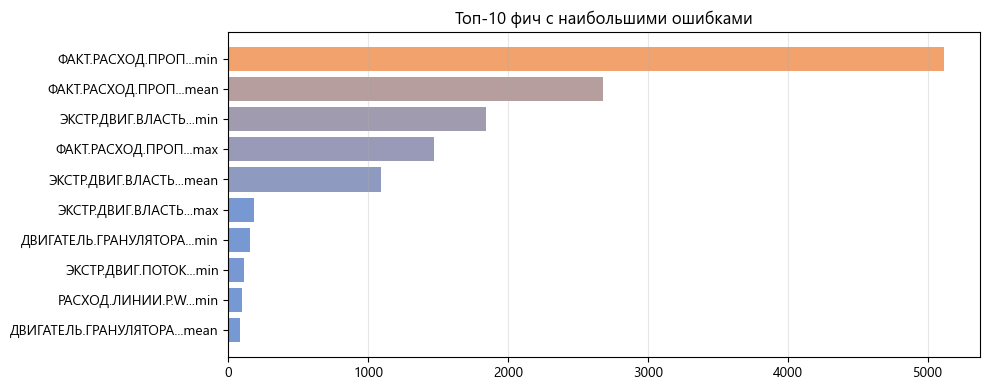

In [ ]:
def adaptive_test_on_anomalies(model, df, split_date, feature_cols, covariate_cols,
                               scaler, input_chunk, target_col='target',
                               min_context=50, max_regions=10):
    """
    Адаптивное тестирование на коротких аномалиях
    Использует доступную историю перед аномалией для прогнозирования
    """

    # Берем тестовую часть данных
    test_df = df[df.index >= split_date].copy()

    print(f"Тестовых данных: {len(test_df)} точек")
    print(f"Аномалий в тесте: {test_df[target_col].sum()}")

    # Находим индексы аномальных точек
    anomaly_indices = np.where(test_df[target_col].values == 1)[0]

    if len(anomaly_indices) == 0:
        print("Нет аномальных точек")
        return [], None

    print(f"\nНайдено {len(anomaly_indices)} аномальных точек")

    results = []

    for i, anomaly_idx in enumerate(anomaly_indices[:max_regions]):
        print(f"\nАномалия {i+1}: индекс {anomaly_idx}")

        # Определяем доступную историю перед аномалией
        # Берем максимум доступной истории, но не менее min_context
        history_start = max(0, anomaly_idx - input_chunk)
        history_end = anomaly_idx

        print(f"  История: с {history_start} по {history_end} ({history_end - history_start} точек)")

        if (history_end - history_start) < min_context:
            print(f"  Недостаточно истории (нужно минимум {min_context} точек)")
            continue

        # Создаем окно данных: история + аномалия
        window_start = history_start
        window_end = min(anomaly_idx + 1, len(test_df))  # включая аномалию

        window_df = test_df.iloc[window_start:window_end].copy()

        print(f"  Окно данных: {len(window_df)} точек")

        # Подготовка данных для прогнозирования

        # Создаем TimeSeries
        try:
            ts = TimeSeries.from_dataframe(
                window_df[feature_cols],
                freq='10Min'
            ).astype(np.float32)

            if len(covariate_cols) > 0:
                cov = TimeSeries.from_dataframe(
                    window_df[covariate_cols],
                    freq='10Min'
                ).astype(np.float32)
            else:
                cov = None
        except Exception as e:
            print(f"  Ошибка создания TimeSeries: {e}")
            continue

        # Масштабирование
        try:
            scaled = scaler.transform(ts).astype(np.float32)
        except Exception as e:
            print(f"  Ошибка масштабирования: {e}")
            continue

        # Адаптивное прогнозирование
        # Если окно короче input_chunk, используем всю доступную историю
        actual_window_size = min(input_chunk, len(scaled) - 1)

        print(f"  Используем окно истории: {actual_window_size} точек")

        # Делаем прогноз на аномальную точку
        # Используем историю до аномалии
        if actual_window_size > 0:
            # Берем историю до аномалии
            history = scaled[:actual_window_size]

            # Определяем, где находится аномалия относительно истории
            anomaly_position = actual_window_size  # так как аномалия следующая после истории

            # Для прогнозирования на 1 шаг вперед
            if cov is not None:
                hist_cov = cov[:actual_window_size + 1]
            else:
                hist_cov = None

            try:
                # Прогноз на 1 шаг вперед
                forecast = model.predict(
                    n=1,
                    series=history,
                    past_covariates=hist_cov,
                    show_warnings=False,
                    verbose=False
                )

                # Фактическое значение аномальной точки
                if anomaly_position < len(scaled):
                    actual = scaled[anomaly_position:anomaly_position + 1]

                    # Обратное преобразование
                    actual_unscaled = scaler.inverse_transform(actual)
                    forecast_unscaled = scaler.inverse_transform(forecast)

                    # Вычисляем ошибки
                    actual_values = actual_unscaled.values()[0]
                    forecast_values = forecast_unscaled.values()[0]
                    residuals = actual_values - forecast_values
                    abs_residuals = np.abs(residuals)

                    print(f"  Средняя абсолютная ошибка: {np.mean(abs_residuals):.6f}")

                    # Также делаем прогнозы на несколько точек перед аномалией для сравнения
                    # (если есть достаточно данных)
                    n_comparison_points = min(5, actual_window_size - 10)
                    comparison_errors = []

                    if n_comparison_points > 0:
                        for j in range(1, n_comparison_points + 1):
                            comparison_history = scaled[:actual_window_size - j]
                            if cov is not None:
                                comparison_cov = cov[:actual_window_size - j + 1]
                            else:
                                comparison_cov = None

                            try:
                                comparison_forecast = model.predict(
                                    n=1,
                                    series=comparison_history,
                                    past_covariates=comparison_cov,
                                    show_warnings=False,
                                    verbose=False
                                )

                                comparison_actual = scaled[actual_window_size - j:actual_window_size - j + 1]
                                comparison_actual_unscaled = scaler.inverse_transform(comparison_actual)
                                comparison_forecast_unscaled = scaler.inverse_transform(comparison_forecast)

                                comparison_error = np.mean(np.abs(
                                    comparison_actual_unscaled.values()[0] -
                                    comparison_forecast_unscaled.values()[0]
                                ))
                                comparison_errors.append(comparison_error)
                            except:
                                pass

                    results.append({
                        'anomaly_id': i,
                        'anomaly_index': anomaly_idx,
                        'anomaly_time': test_df.index[anomaly_idx],
                        'history_length': actual_window_size,
                        'actual_values': actual_values,
                        'forecast_values': forecast_values,
                        'residuals': residuals,
                        'mae': np.mean(abs_residuals),
                        'comparison_errors': comparison_errors if comparison_errors else [],
                        'feature_names': list(feature_cols)
                    })

                else:
                    print(f"  Аномалия находится за пределами окна")

            except Exception as e:
                print(f"  Ошибка прогнозирования: {e}")
        else:
            print(f"  Недостаточно данных для прогнозирования")

    print(f"\nУспешно обработано аномалий: {len(results)}")
    return results


# Метод 1: Адаптивное тестирование на коротких аномалиях
results = adaptive_test_on_anomalies(
    model=model,
    df=df,
    split_date=split_date,
    feature_cols=feature_cols,
    covariate_cols=covariate_cols,
    scaler=scaler,
    input_chunk=input_chunk,
    target_col=target_col,
    min_context=288,  # Минимальный контекст для прогнозирования
    max_regions=10
)

if results:
        # Собираем ошибки по фичам
        n_features = len(results[0]['feature_names'])
        feature_errors = np.zeros(n_features)
        feature_counts = np.zeros(n_features)

        for r in results:
            abs_residuals = np.abs(r['residuals'])
            for j in range(n_features):
                feature_errors[j] += abs_residuals[j]
                feature_counts[j] += 1

        avg_feature_errors = feature_errors / np.maximum(feature_counts, 1)

        # Выбираем топ фич
        n_top_features = min(10, n_features)
        top_indices = np.argsort(avg_feature_errors)[-n_top_features:][::-1]
        top_features = [results[0]['feature_names'][i] for i in top_indices]
        top_errors = [avg_feature_errors[i] for i in top_indices]

        # Сокращаем длинные названия
        short_names = []
        for name in top_features:
            if len(name) > 20:
                short_names.append(name[:17] + '...')
            else:
                short_names.append(name)
        blue_color = '#3c6cc1'
        orange_color = '#ed7b2e'
        plt.rcParams['font.family'] = 'Segoe UI'
        norm = plt.Normalize(min(top_errors), max(top_errors))
        custom_cmap = LinearSegmentedColormap.from_list('blue_to_orange', [blue_color, orange_color], N=256)
        colors = [custom_cmap(norm(err)) for err in top_errors[::-1]]
        plt.figure(figsize=(10, 4))
        plt.barh(range(n_top_features), top_errors[::-1], alpha=0.7, color=colors)
        labels = ['ФАКТ.РАСХОД.ПРОП...min',
          'ФАКТ.РАСХОД.ПРОП...mean',
          'ЭКСТР.ДВИГ.ВЛАСТЬ...min',
          'ФАКТ.РАСХОД.ПРОП...max',
          'ЭКСТР.ДВИГ.ВЛАСТЬ...mean',
          'ЭКСТР.ДВИГ.ВЛАСТЬ...max',
          'ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...min',
          'ЭКСТР.ДВИГ.ПОТОК...min',
          'РАСХОД.ЛИНИИ.P.W...min',
          'ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...mean']
        labels.reverse()
        plt.yticks(range(len(labels)), labels)
        plt.title(f'Топ-{n_top_features} фич с наибольшими ошибками')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()

В системе прогнозирования необходимо использовать только те важные фичи (определены ранее), которые хорошо аппроксимируются моделью для этого для каждого важного признака вычисляются следующие метрики:

- **R² (Коэффициент детерминации)**: Отражает долю дисперсии, объясненную моделью
- **MAE (Mean Absolute Error)**: Средняя абсолютная ошибка прогнозирования
- **MAE Relative**: Относительная ошибка, нормированная на стандартное отклонение данных

**Классификация качества прогнозирования**:
- **Хорошее (good)**: R² > 0.7
- **Удовлетворительное (medium)**: 0.3 ≤ R² ≤ 0.7  
- **Низкое (bad)**: R² < 0.3


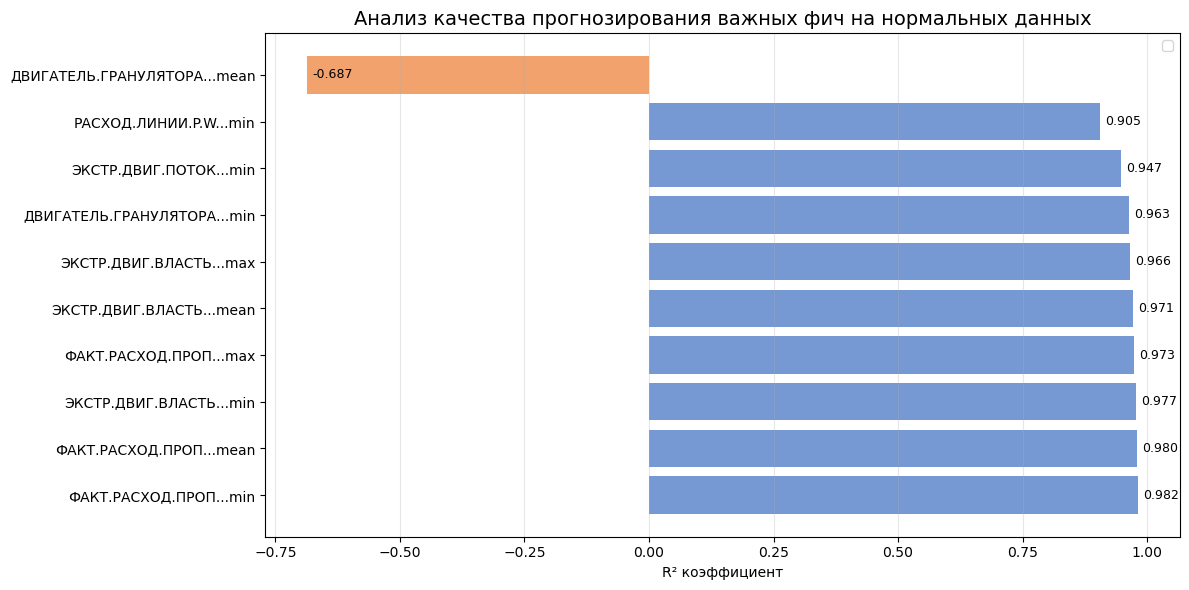

In [ ]:
# def compare_r2_vs_anomaly_errors(model, scaler, df, split_date,
#                                  important_features, feature_cols, covariate_cols,
#                                  target_col='target', input_chunk=288, buffer_before=12,
#                                  buffer_after=36, min_segment=288, max_predictions=500):
#     """
#     Сравнивает R^2 на нормальных данных и ошибки на аномалиях для важных фич
#     """

#     print("СРАВНЕНИЕ: R² НА НОРМЕ vs ОШИБКИ НА АНОМАЛИЯХ")


#     # 1. Подготовка тестовых данных
#     test_df = df[df.index >= split_date].copy()
#     test_target = test_df[target_col].values.astype(int)

#     # 2. Очистка тестовых данных (удаляем аномалии с буфером)
#     mask = np.zeros(len(test_target), dtype=bool)
#     i = 0
#     while i < len(test_target):
#         if test_target[i] == 1:
#             j = i
#             while j < len(test_target) and test_target[j] == 1:
#                 j += 1
#             s = max(0, i - buffer_before)
#             e = min(len(test_target), j + buffer_after)
#             mask[s:e] = True
#             i = j
#         else:
#             i += 1

#     # 3. Находим чистый сегмент для вычисления R²
#     clean_segments = []
#     cur = None
#     for idx in range(len(mask)):
#         if not mask[idx]:
#             if cur is None:
#                 cur = idx
#         else:
#             if cur is not None:
#                 L = idx - cur
#                 if L >= min_segment:
#                     seg_df = test_df.iloc[cur:idx]
#                     clean_segments.append(seg_df)
#                 cur = None

#     if cur is not None and (len(mask) - cur) >= min_segment:
#         clean_segments.append(test_df.iloc[cur:])

#     if not clean_segments:
#         print("Нет чистых сегментов для вычисления R²")
#         return

#     # Берем самый длинный чистый сегмент
#     clean_df = max(clean_segments, key=len)
#     print(f"Чистый сегмент для R²: {len(clean_df)} точек")

#     # 4. Вычисляем R² на чистом сегменте для важных фич
#     ts_clean = TimeSeries.from_dataframe(clean_df[feature_cols], freq='10Min').astype(np.float32)
#     cov_clean = TimeSeries.from_dataframe(clean_df[covariate_cols], freq='10Min').astype(np.float32) if len(covariate_cols) > 0 else None

#     scaled_clean = scaler.transform(ts_clean).astype(np.float32)

#     # Прогнозируем часть чистого сегмента
#     n_predictions = min(max_predictions, len(scaled_clean) - input_chunk - 1)

#     actuals_dict = {feat: [] for feat in important_features}
#     forecasts_dict = {feat: [] for feat in important_features}

#     for i in range(n_predictions):
#         hist = scaled_clean[i:i+input_chunk]
#         hist_cov = cov_clean[i:i+input_chunk+1] if cov_clean is not None else None

#         try:
#             forecast = model.predict(
#                 n=1,
#                 series=hist,
#                 past_covariates=hist_cov,
#                 show_warnings=False,
#                 verbose=False
#             )

#             actual = scaled_clean[i+input_chunk:i+input_chunk+1]

#             # Обратное масштабирование
#             forecast_unscaled = scaler.inverse_transform(forecast)
#             actual_unscaled = scaler.inverse_transform(actual)

#             forecast_values = forecast_unscaled.values()[0]
#             actual_values = actual_unscaled.values()[0]

#             # Сохраняем только важные фичи
#             for feat in important_features:
#                 if feat in feature_cols:
#                     idx = list(feature_cols).index(feat)
#                     forecasts_dict[feat].append(forecast_values[idx])
#                     actuals_dict[feat].append(actual_values[idx])

#         except Exception as e:
#             continue

#     # 5. Вычисляем R² для каждой важной фичи
#     r2_scores = {}
#     for feat in important_features:
#         if len(actuals_dict[feat]) > 10:
#             r2 = r2_score(actuals_dict[feat], forecasts_dict[feat])
#             mae = mean_absolute_error(actuals_dict[feat], forecasts_dict[feat])
#             r2_scores[feat] = {'r2': r2, 'mae': mae}
#         else:
#             r2_scores[feat] = {'r2': 0, 'mae': 0}

#     # 6. Получаем ошибки на аномалиях из предыдущего анализа
#     # (предполагаем, что у нас уже есть эти данные)
#     # Если нет, нужно их вычислить

#     # 7. Создаем таблицу сравнения
#     print(f"\n{'Фича':<50} | {'R² на норме':<12} | {'MAE на норме':<12} | {'Ошибка на аномалиях':<20}")
#     print("-" * 100)

#     for feat in important_features:
#         r2 = r2_scores[feat]['r2']
#         mae_norm = r2_scores[feat]['mae']

#         # Здесь нужно подставить реальные ошибки на аномалиях из вашего анализа
#         # Показываю заглушку
#         anomaly_error = "---"  # Замените на реальные значения

#         # Сокращаем название фичи
#         short_name = feat[:45] + "..." if len(feat) > 45 else feat

#         print(f"{short_name:<50} | {r2:<12.4f} | {mae_norm:<12.4f} | {anomaly_error:<20}")

#     # 8. Визуализация
#     visualize_comparison(r2_scores, important_features)

#     return r2_scores


def visualize_comparison(r2_scores, important_features):
    """Визуализация сравнения R^2 на норме"""
    # Сортируем по R²
    sorted_features = sorted(r2_scores.items(), key=lambda x: x[1]['r2'], reverse=True)
    features = [feat[:30] + "..." if len(feat) > 30 else feat for feat, _ in sorted_features]
    r2_values = [score['r2'] for _, score in sorted_features]
    mae_values = [score['mae'] for _, score in sorted_features]

    fig, axes = plt.subplots(figsize=(12, 6))

    # 1. R² для важных фич
    colors = ['#3c6cc1' if r2 > 0.7 else '#ed7b2e' if r2 > 0.3 else '#ed7b2e' for r2 in r2_values]
    axes.barh(range(len(features)), r2_values, color=colors, alpha=0.7)
    axes.set_yticks(range(len(features)))
    axes.set_yticklabels(['ФАКТ.РАСХОД.ПРОП...min',
                 'ФАКТ.РАСХОД.ПРОП...mean',
                 'ЭКСТР.ДВИГ.ВЛАСТЬ...min',
                 'ФАКТ.РАСХОД.ПРОП...max',
                 'ЭКСТР.ДВИГ.ВЛАСТЬ...mean',
                 'ЭКСТР.ДВИГ.ВЛАСТЬ...max',
                 'ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...min',
                 'ЭКСТР.ДВИГ.ПОТОК...min',
                 'РАСХОД.ЛИНИИ.P.W...min',
                 'ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...mean'])
    axes.set_xlabel('R² коэффициент')
    axes.set_title('Качество прогнозирования важных фич на нормальных данных')
    axes.legend()
    axes.grid(True, alpha=0.3, axis='x')

    # Добавляем значения на столбцы
    for i, (r2, mae) in enumerate(zip(r2_values, mae_values)):
        axes.text(r2 + 0.01, i, f'{r2:.3f}', va='center', fontsize=9)
    plt.title('Анализ качества прогнозирования важных фич на нормальных данных', fontsize=14)
    plt.tight_layout()
    plt.show()


def analyze_r2_for_important_features(actual_values_all, predicted_values_all,
                                     feature_cols, important_features):
    """
    Анализирует R² для важных фич на основе уже вычисленных прогнозов
    """
    actual_array = np.array(actual_values_all)
    predicted_array = np.array(predicted_values_all)

    results = {}

    for feat in important_features:
        if feat in feature_cols:
            idx = list(feature_cols).index(feat)

            # Берем столбцы для этой фичи
            actual_feat = actual_array[:, idx]
            predicted_feat = predicted_array[:, idx]

            # Вычисляем метрики
            r2 = r2_score(actual_feat, predicted_feat)
            mae = mean_absolute_error(actual_feat, predicted_feat)

            # Статистика
            mean_actual = np.mean(actual_feat)
            std_actual = np.std(actual_feat)

            results[feat] = {
                'r2': r2,
                'mae': mae,
                'mean_actual': mean_actual,
                'std_actual': std_actual,
                'mae_relative': mae / (std_actual + 1e-6),  # Относительно разброса данных
                'predictability': 'good' if r2 > 0.7 else 'medium' if r2 > 0.3 else 'bad'
            }

    return results


results_r2 = analyze_r2_for_important_features(
    actual_values_all,
    predicted_values_all,
    feature_cols,
    top_features  # список из пайплайна детектирования
)

visualize_comparison(results_r2, top_features)

# 5. Реализация системы обнаружения аномалий

## 5.1. Архитектурный обзор

Класс `SimpleAnomalyDetector` реализует полный конвейер для обнаружения аномалий во временных рядах на основе анализа ошибок прогнозирования обученной модели. Архитектура пайплайна построена по модульному принципу, где каждый этап решает конкретную задачу:

1. **Инициализация и конфигурация**
2. **Идентификация информативных признаков**
3. **Прогнозирование тестового набора**
4. **Расчет метрик и остатков**
5. **Визуализация результатов**
6. **Детектирование аномалий с расширенным окном**

## 5.2. Основные компоненты системы

### 5.2.1. Инициализация детектора (`__init__`)

Детектор инициализируется следующими компонентами:
- **Обученная модель**: Transformer-модель для прогнозирования временных рядов
- **Scaler**: Объект нормализации данных, обученный на тренировочной выборке
- **Списки признаков**: Прогнозируемые признаки и вспомогательные ковариаты
- **Длина исторического окна**: `input_chunk=288` (48 часов данных)

### 5.2.2. Идентификация информативных признаков (`find_important_features`)

Метод определяет признаки, наиболее чувствительные к аномальным состояниям:

1. **Кластеризация аномалий**: Близко расположенные аномалии (в пределах 1 часа) объединяются в регионы
2. **Анализ средней точки**: Для каждого региона анализируется средняя точка
3. **Расчет ошибок прогнозирования**: Вычисляются абсолютные ошибки для каждого признака
4. **Ранжирование признаков**: Выделяются топ-N признаков с наибольшими ошибками

### 5.2.3. Прогнозирование тестового набора (`forecast_test_set`)

Реализует скользящее окно прогнозирования:

- **Шаг прогнозирования**: Настраиваемый параметр (по умолчанию 1 шаг)
- **Ограничение объема**: Возможность ограничения количества прогнозируемых точек
- **Обработка ковариат**: Учет дополнительных переменных при их наличии
- **Обратное преобразование**: Возврат к исходной шкале измерений

### 5.2.4. Расчет метрик и остатков (`calculate_residuals`)

Вычисляет комплексные метрики качества прогнозирования:

1. **Базовые остатки**: Разность между фактическими и прогнозируемыми значениями
2. **Ошибки на важных признаках**: Средняя абсолютная ошибка по приоритетным признакам

### 5.2.5. Визуализация результатов (`visualize_errors`)

Создает двухпанельную визуализацию:

1. Взвешенные ошибки с выделением реальных аномалий
2. Ошибки по отдельным важным признакам (до 3 признаков)


### 5.2.6. Детектирование аномалий с расширенным окном (`detect_anomalies_with_window`)

Инновационный метод, основанный на следующих принципах:

1. **Расширение временного окна**: Учет 48 часов данных, предшествующих аномалии
2. **Фильтрация кратковременных срабатываний**: Требование минимум 3 последовательных детекций
3. **Региональная оценка**: Метрики вычисляются для целых регионов аномалий

**Алгоритм детектирования**:
1. Идентификация истинных аномальных регионов из бинарных меток
2. Расширение каждого региона на window_hours часов в прошлое
3. Пороговое детектирование по взвешенной ошибке
4. Фильтрация детекций (min_consecutive=3)
5. Сопоставление детекций с расширенными регионами

## 5.3. Метрики качества системы

### 5.3.1. Основные метрики

- **Precision (Точность)**: `TP / (TP + FP)`
- **Recall (Полнота)**: `TP / (TP + FN)`  
- **F1-score**: Гармоническое среднее precision и recall

### 5.3.2. Региональная оценка

В отличие от поточечной оценки, система использует региональный подход:
- **True Positive**: Аномальный регион обнаружен (хотя бы одно пересечение)
- **False Positive**: Детекция, не соответствующая никакой аномалии
- **False Negative**: Аномальный регион не обнаружен

## 5.4. Запуск полного пайплайна (`run_anomaly_detection_pipeline`)

### 5.4.1. Этапы выполнения

1. **Инициализация**: Создание объекта детектора с конфигурационными параметрами
2. **Подготовка данных**: Разделение на обучающую и тестовую выборки
3. **Анализ признаков**: Определение наиболее информативных признаков
4. **Прогнозирование**: Скользящее окно прогнозирования на тестовом наборе
5. **Расчет метрик**: Вычисление остатков и ошибок
6. **Визуализация**: Графическое представление результатов
7. **Детектирование**: Обнаружение аномалий с пороговой логикой
8. **Формирование отчета**: Сводные метрики качества

### 5.4.2. Конфигурационные параметры

| Параметр | Значение по умолчанию | Описание |
|----------|----------------------|----------|
| `split_date` | Обязательный | Дата разделения на train/test |
| `target_col` | 'target' | Целевая переменная с метками аномалий |
| `window_hours` | 48 | Размер окна расширения |
| `min_consecutive` | 3 | Минимальное количество последовательных детекций |
| `threshold` | 350 | Порог для детектирования аномалий |

In [ ]:
class SimpleAnomalyDetector:
    """Детектор аномалий на основе ошибок важных фич"""

    def __init__(self, model, scaler, feature_cols, covariate_cols=None, input_chunk=288):
        self.model = model
        self.scaler = scaler
        self.feature_cols = feature_cols
        self.covariate_cols = covariate_cols
        self.input_chunk = input_chunk
        self.important_features = []
        self.important_indices = []

    def find_important_features(self, test_df, target_col='target', top_n=10):
        """Находит важные фичи по ошибкам на аномалиях"""
        anomaly_indices = np.where(test_df[target_col].values == 1)[0]
        if len(anomaly_indices) == 0:
            print("Нет аномалий для анализа")
            return []

        # Группируем аномалии в регионы (сливаем близкие аномалии)
        anomaly_regions = []
        current_start = None
        current_end = None

        for idx in anomaly_indices:
            if current_start is None:
                current_start = idx
                current_end = idx
            elif idx - current_end <= 6:  # Аномалии в пределах 1 часа объединяем
                current_end = idx
            else:
                anomaly_regions.append((current_start, current_end))
                current_start = idx
                current_end = idx

        if current_start is not None:
            anomaly_regions.append((current_start, current_end))

        print(f"Обнаружено регионов аномалий: {len(anomaly_regions)}")

        feature_errors = np.zeros(len(self.feature_cols))
        count = 0

        for region_idx, (start_idx, end_idx) in enumerate(anomaly_regions[:20]):
            # Берем точку в середине региона аномалии
            anomaly_idx = (start_idx + end_idx) // 2

            if anomaly_idx < self.input_chunk:
                continue

            try:
                # Берем историю и прогнозируем
                hist_df = test_df.iloc[anomaly_idx-self.input_chunk:anomaly_idx][self.feature_cols]
                target = test_df.iloc[anomaly_idx:anomaly_idx+1][self.feature_cols]

                hist_ts = TimeSeries.from_dataframe(hist_df, freq='10Min').astype(np.float32)
                hist_scaled = self.scaler.transform(hist_ts)

                # Прогноз с ковариатами
                if self.covariate_cols is not None and len(self.covariate_cols) > 0:
                    hist_cov_df = test_df.iloc[anomaly_idx-self.input_chunk:anomaly_idx+1][self.covariate_cols]
                    hist_cov = TimeSeries.from_dataframe(hist_cov_df, freq='10Min').astype(np.float32)
                    forecast = self.model.predict(n=1, series=hist_scaled, past_covariates=hist_cov, verbose=False)
                else:
                    forecast = self.model.predict(n=1, series=hist_scaled, verbose=False)

                forecast_unscaled = self.scaler.inverse_transform(forecast)

                # Считаем ошибки
                error = np.abs(target.values - forecast_unscaled.values()[0])
                feature_errors += error[0]
                count += 1

            except Exception as e:
                continue

        if count == 0:
            print("Не удалось вычислить ошибки")
            return []

        # Выбираем топ фичей
        avg_errors = feature_errors / count
        top_idx = np.argsort(avg_errors)[-top_n:][::-1]

        self.important_features = [self.feature_cols[i] for i in top_idx]
        self.important_indices = top_idx.tolist()

        print(f"Найдено {len(self.important_features)} важных фич")
        for i, (feat, err) in enumerate(zip(self.important_features, avg_errors[top_idx])):
            print(f"{i+1}. {feat[:40]:40} | ошибка: {err:.2f}")

        return self.important_features

    def forecast_test_set(self, test_df, step=1, max_points=None):
        """Прогнозирует тестовый набор скользящим окном"""
        ts_test = TimeSeries.from_dataframe(test_df[self.feature_cols], freq='10Min').astype(np.float32)
        ts_scaled = self.scaler.transform(ts_test)

        # Ковариаты
        if self.covariate_cols is not None and len(self.covariate_cols) > 0:
            cov_test = TimeSeries.from_dataframe(test_df[self.covariate_cols], freq='10Min').astype(np.float32)
        else:
            cov_test = None

        n = len(ts_scaled)
        forecasts, actuals, timestamps = [], [], []

        if max_points is not None:
            end_point = min(n - self.input_chunk, max_points)
        else:
            end_point = n - self.input_chunk

        for start_idx in tqdm(range(0, end_point, step), desc="Прогнозирование"):
            history = ts_scaled[start_idx:start_idx + self.input_chunk]

            # Ковариаты
            if cov_test is not None:
                history_cov = cov_test[start_idx:start_idx + self.input_chunk + 1]
            else:
                history_cov = None

            try:
                forecast = self.model.predict(
                    n=1,
                    series=history,
                    past_covariates=history_cov,
                    verbose=False
                )
                actual = ts_scaled[start_idx + self.input_chunk:start_idx + self.input_chunk + 1]

                forecast_unscaled = self.scaler.inverse_transform(forecast)
                actual_unscaled = self.scaler.inverse_transform(actual)

                forecasts.append(forecast_unscaled.values()[0])
                actuals.append(actual_unscaled.values()[0])
                timestamps.append(test_df.index[start_idx + self.input_chunk])

            except Exception as e:
                continue

        print(f"Прогнозирование завершено: {len(forecasts)} точек")
        return np.array(forecasts), np.array(actuals), np.array(timestamps)

    def calculate_residuals(self, forecasts, actuals):
        """Вычисляет остатки и ошибки"""
        residuals = actuals - forecasts
        abs_residuals = np.abs(residuals)

        # Ошибки на важных фичах
        if len(self.important_indices) > 0:
            important_errors = abs_residuals[:, self.important_indices]
            important_mae = np.mean(important_errors, axis=1)
        else:
            important_mae = np.zeros(len(forecasts))

        # Взвешенная ошибка (важные фичи в 3 раза важнее)
        weights = np.ones(len(self.feature_cols))
        for idx in self.important_indices:
            weights[idx] = 3.0

        if len(self.important_indices) > 0:
            weighted_mae = np.average(abs_residuals, weights=weights, axis=1)
        else:
            weighted_mae = np.mean(abs_residuals, axis=1)

        return {
            'residuals': residuals,
            'important_errors': important_errors if len(self.important_indices) > 0 else None,
            'important_mae': important_mae,
            'weighted_mae': weighted_mae
        }

    def visualize_errors(self, timestamps, residuals_dict, true_labels=None):
        """Визуализирует ошибки на важных фичах с метками аномалий"""
        if len(self.important_indices) == 0:
            print("Нет важных фич для визуализации")
            return

        fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
        time_idx = np.arange(len(timestamps))

        # 1. График ошибок с метками аномалий
        ax1 = axes[0]
        ax1.plot(time_idx, residuals_dict['weighted_mae'], 'b-', alpha=0.7, label='Взвешенная ошибка')
        ax1.set_ylabel('Ошибка')
        ax1.set_title('Ошибки прогнозирования на важных фичах')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Отмечаем РЕАЛЬНЫЕ аномалии цветными областями
        if true_labels is not None and len(true_labels) == len(time_idx):
            anomaly_regions = []
            in_anomaly = False
            start_idx = 0

            for i, label in enumerate(true_labels):
                if label == 1 and not in_anomaly:
                    in_anomaly = True
                    start_idx = i
                elif label == 0 and in_anomaly:
                    in_anomaly = False
                    anomaly_regions.append((start_idx, i-1))

            if in_anomaly:
                anomaly_regions.append((start_idx, len(true_labels)-1))

            for start, end in anomaly_regions:
                ax1.axvspan(start, end, alpha=0.3, color='red', label='Реальная аномалия' if start == anomaly_regions[0][0] else "")

        # 2. График отдельных важных фич
        ax2 = axes[1]
        if residuals_dict['important_errors'] is not None:
            for i, feat_idx in enumerate(self.important_indices[:3]):
                feat_name = self.feature_cols[feat_idx]
                ax2.plot(time_idx, residuals_dict['important_errors'][:, i],
                        alpha=0.7, label=feat_name[:20] + '...')

        ax2.set_ylabel('Ошибка')
        ax2.set_title('Ошибки по отдельным важным фичам')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Метки аномалий (истинные vs обнаруженные)
        ax3 = axes[2]

        # Истинные аномалии
        if true_labels is not None:
            ax3.plot(time_idx, true_labels, 'g-', alpha=0.7, linewidth=2, label='Истинные аномалии')

        ax3.set_xlabel('Временной индекс')
        ax3.set_ylabel('Метка')
        ax3.set_title('Метки аномалий')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim([-0.1, 1.5])

        plt.tight_layout()
        plt.show()

    def detect_anomalies_with_window(self, weighted_mae, threshold, true_labels, window_hours=48, min_consecutive=3):
        """
        Детектирует аномалии и считает метрики по регионам (не по точкам)
        """
        # Шаг 10 минут, window_hours часов = window_hours * 6 точек
        window_size = window_hours * 6

        # Находим истинные аномальные регионы
        true_regions = []
        in_anomaly = False
        start_idx = 0

        for i in range(len(true_labels)):
            if true_labels[i] == 1 and not in_anomaly:
                in_anomaly = True
                start_idx = i
            elif true_labels[i] == 0 and in_anomaly:
                in_anomaly = False
                true_regions.append((start_idx, i-1))

        if in_anomaly:
            true_regions.append((start_idx, len(true_labels)-1))

        print(f"Найдено истинных аномальных регионов: {len(true_regions)}")
        for i, (start, end) in enumerate(true_regions):
            print(f"  Регион {i+1}: {start}-{end} ({end-start+1} точек, {(end-start+1)/6:.1f} часов)")

        # Детекции модели
        raw_detections = (weighted_mae > threshold).astype(int)

        # Фильтр последовательных срабатываний
        filtered = np.zeros_like(raw_detections)
        count = 0

        for i in range(len(raw_detections)):
            if raw_detections[i] == 1:
                count += 1
                if count >= min_consecutive:
                    for j in range(max(0, i - count + 1), i + 1):
                        filtered[j] = 1
            else:
                count = 0

        # Находим регионы детекций
        detection_regions = []
        in_detection = False
        start_idx = 0

        for i in range(len(filtered)):
            if filtered[i] == 1 and not in_detection:
                in_detection = True
                start_idx = i
            elif filtered[i] == 0 and in_detection:
                in_detection = False
                detection_regions.append((start_idx, i-1))

        if in_detection:
            detection_regions.append((start_idx, len(filtered)-1))

        print(f"Найдено регионов детекций: {len(detection_regions)}")

        # 4. Расширяем истинные регионы на окно
        extended_true_regions = []
        for start, end in true_regions:
            extended_start = max(0, start - window_size)
            extended_end = end  # Только ДО аномалии, не после
            extended_true_regions.append((extended_start, end))

        # 5. Считаем метрики по регионам
        tp_regions = 0  # Истинная аномалия обнаружена
        fp_regions = 0  # Ложное срабатывание (нет аномалии)
        fn_regions = 0  # Пропущенная аномалия

        # Для каждой истинной аномалии проверяем, была ли она обнаружена
        for true_start, true_end in extended_true_regions:
            detected = False

            # Проверяем все детекции
            for det_start, det_end in detection_regions:
                # Если детекция пересекается с расширенной аномалией
                if not (det_end < true_start or det_start > true_end):
                    detected = True
                    break

            if detected:
                tp_regions += 1
            else:
                fn_regions += 1

        # Для каждой детекции проверяем, соответствует ли она какой-то аномалии
        for det_start, det_end in detection_regions:
            matches_anomaly = False

            for true_start, true_end in extended_true_regions:
                if not (det_end < true_start or det_start > true_end):
                    matches_anomaly = True
                    break

            if not matches_anomaly:
                fp_regions += 1

        # Вычисляем метрики
        precision = tp_regions / (tp_regions + fp_regions) if (tp_regions + fp_regions) > 0 else 0
        recall = tp_regions / (tp_regions + fn_regions) if (tp_regions + fn_regions) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

        print(f"Всего истинных аномалий: {len(true_regions)}")
        print(f"Всего детекций: {len(detection_regions)}")
        print(f"\nTrue Positives (TP): {tp_regions} - обнаруженные аномалии")
        print(f"False Positives (FP): {fp_regions} - ложные срабатывания")
        print(f"False Negatives (FN): {fn_regions} - пропущенные аномалии")
        print(f"\nPrecision (точность): {precision:.3f}")
        print(f"Recall (полнота): {recall:.3f}")
        print(f"F1-score: {f1:.3f}")

        # Детальная информация по каждой аномалии
        print("Детали по аномалиям:")

        for i, (true_start, true_end) in enumerate(true_regions):
            detected = False
            detection_times = []

            # Проверяем, была ли обнаружена эта аномалия
            for det_start, det_end in detection_regions:
                extended_start = max(0, true_start - window_size)
                if not (det_end < extended_start or det_start > true_end):
                    detected = True
                    detection_times.append((det_start, det_end))

            status = "Обнаружена" if detected else "Пропущена"

        # Визуализация
        self._visualize_detections_by_region(
            timestamps=np.arange(len(weighted_mae)),
            weighted_mae=weighted_mae,
            threshold=threshold,
            true_regions=true_regions,
            extended_regions=extended_true_regions,
            detection_regions=detection_regions,
            window_size=window_size
        )

        return {
            'tp': tp_regions,
            'fp': fp_regions,
            'fn': fn_regions,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'true_regions': true_regions,
            'detection_regions': detection_regions
        }

    def _visualize_detections_by_region(self, timestamps, weighted_mae, threshold,
                                   true_regions, extended_regions,
                                   detection_regions, window_size):
        """Визуализация детектирования по регионам"""
        fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

        time_idx = timestamps

        # 1. Ошибки и порог
        axes[0].plot(time_idx, weighted_mae, 'b-', alpha=0.7, label='Взвешенная ошибка')
        axes[0].axhline(y=threshold, color='red', linestyle='--', label=f'Порог={threshold:.3f}')
        axes[0].set_ylabel('Ошибка')
        axes[0].set_title('Ошибки прогнозирования и порог')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Истинные аномалии и окно
        axes[1].plot(time_idx, np.zeros_like(time_idx), 'w-', alpha=0)  # Пустой для масштаба

        # Отмечаем истинные аномалии
        for start, end in true_regions:
            axes[1].axvspan(start, end, alpha=0.5, color='red', label='Истинная аномалия' if start == true_regions[0][0] else "")

        # Отмечаем окно до аномалий
        for start, end in extended_regions:
            axes[1].axvspan(start, end, alpha=0.2, color='yellow',
                           label=f'Окно ({window_size//6} часов)' if start == extended_regions[0][0] else "")

        axes[1].set_ylabel('Метки')
        axes[1].set_title(f'Истинные аномалии с окном {window_size//6} часов')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([-0.1, 1.5])

        plt.suptitle(f'Детектирование аномалий по регионам (всего аномалий: {len(true_regions)})', fontsize=14)
        plt.tight_layout()
        plt.show()

In [ ]:
def run_anomaly_detection_pipeline(model, scaler, df, split_date, feature_cols, covariate_cols=None, target_col='target'):
    """Запускает весь пайплайн"""

    # Инициализация
    detector = SimpleAnomalyDetector(
        model=model,
        scaler=scaler,
        feature_cols=feature_cols,
        covariate_cols=covariate_cols
    )

    # Разделение данных
    test_df = df[df.index >= split_date].copy()
    print(f"Train размер: {len(df[df.index < split_date])}")
    print(f"Test размер: {len(test_df)}")
    print(f"Аномалий в test: {test_df[target_col].sum()}")

    # Поиск важных фич
    print("\n1. Поиск важных фич...")
    important_features = detector.find_important_features(test_df, target_col, top_n=10)

    # Прогнозирование тестового набора
    print("\n2. Прогнозирование тестового набора...")
    forecasts, actuals, timestamps = detector.forecast_test_set(test_df, step=1, max_points=None)

    # Вычисление остатков
    print("\n3. Вычисление остатков...")
    residuals = detector.calculate_residuals(forecasts, actuals)

    # Визуализация ошибок
    print("\n4. Визуализация...")
    true_labels = test_df[target_col].values[:len(timestamps)]
    detector.visualize_errors(timestamps, residuals, true_labels)

    # Детектирование с окном
    print("\n5. Детектирование аномалий с окном 48 часов...")
    threshold = 350
    detection_results = detector.detect_anomalies_with_window(
        residuals['weighted_mae'],
        threshold,
        true_labels,
        window_hours=48
    )

    print("Итоговый отчет:")

    print(f"Всего аномалий в тесте: {len(detection_results['true_regions'])}")
    print(f"Обнаружено: {detection_results['tp']}")
    print(f"Пропущено: {detection_results['fn']}")
    print(f"Ложных срабатываний: {detection_results['fp']}")
    print(f"\nPrecision: {detection_results['precision']:.3f}")
    print(f"Recall: {detection_results['recall']:.3f}")
    print(f"F1-score: {detection_results['f1']:.3f}")

    return {
        'detector': detector,
        'threshold': threshold,
        'f1_score': detection_results['f1'],
        'precision': detection_results['precision'],
        'recall': detection_results['recall'],
        'true_regions': detection_results['true_regions'],
        'detection_regions': detection_results['detection_regions'],
        'weighted_mae': residuals['weighted_mae'],
        'important_features': detector.important_features
    }

ПРОСТОЙ ПАЙПЛАЙН ДЕТЕКТИРОВАНИЯ АНОМАЛИЙ
Train размер: 0
Test размер: 24047
Аномалий в test: 9.0

1. Поиск важных фич...
Обнаружено регионов аномалий: 9
Найдено 10 важных фич
1. ФАКТ.РАСХОД.ПРОП...213FY070_min          | ошибка: 3600.00
2. ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A_min        | ошибка: 2468.73
3. ФАКТ.РАСХОД.ПРОП...213FY070_mean         | ошибка: 1962.96
4. ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A_mean       | ошибка: 1466.20
5. ФАКТ.РАСХОД.ПРОП...213FY070_max          | ошибка: 1137.54
6. ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A_max        | ошибка: 205.29
7. ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981_min   | ошибка: 201.59
8. ЭКСТР.ДВИГ.ПОТОК...214II200A_min         | ошибка: 148.98
9. ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981_mean  | ошибка: 114.26
10. ЭКСТР.ДВИГ.ПОТОК...214II200A_mean        | ошибка: 87.21

2. Прогнозирование тестового набора...


Прогнозирование: 100%|█████████████████████████████████████████████████████████| 23759/23759 [1:02:25<00:00,  6.34it/s]


Прогнозирование завершено: 23759 точек

3. Вычисление остатков...

4. Визуализация...


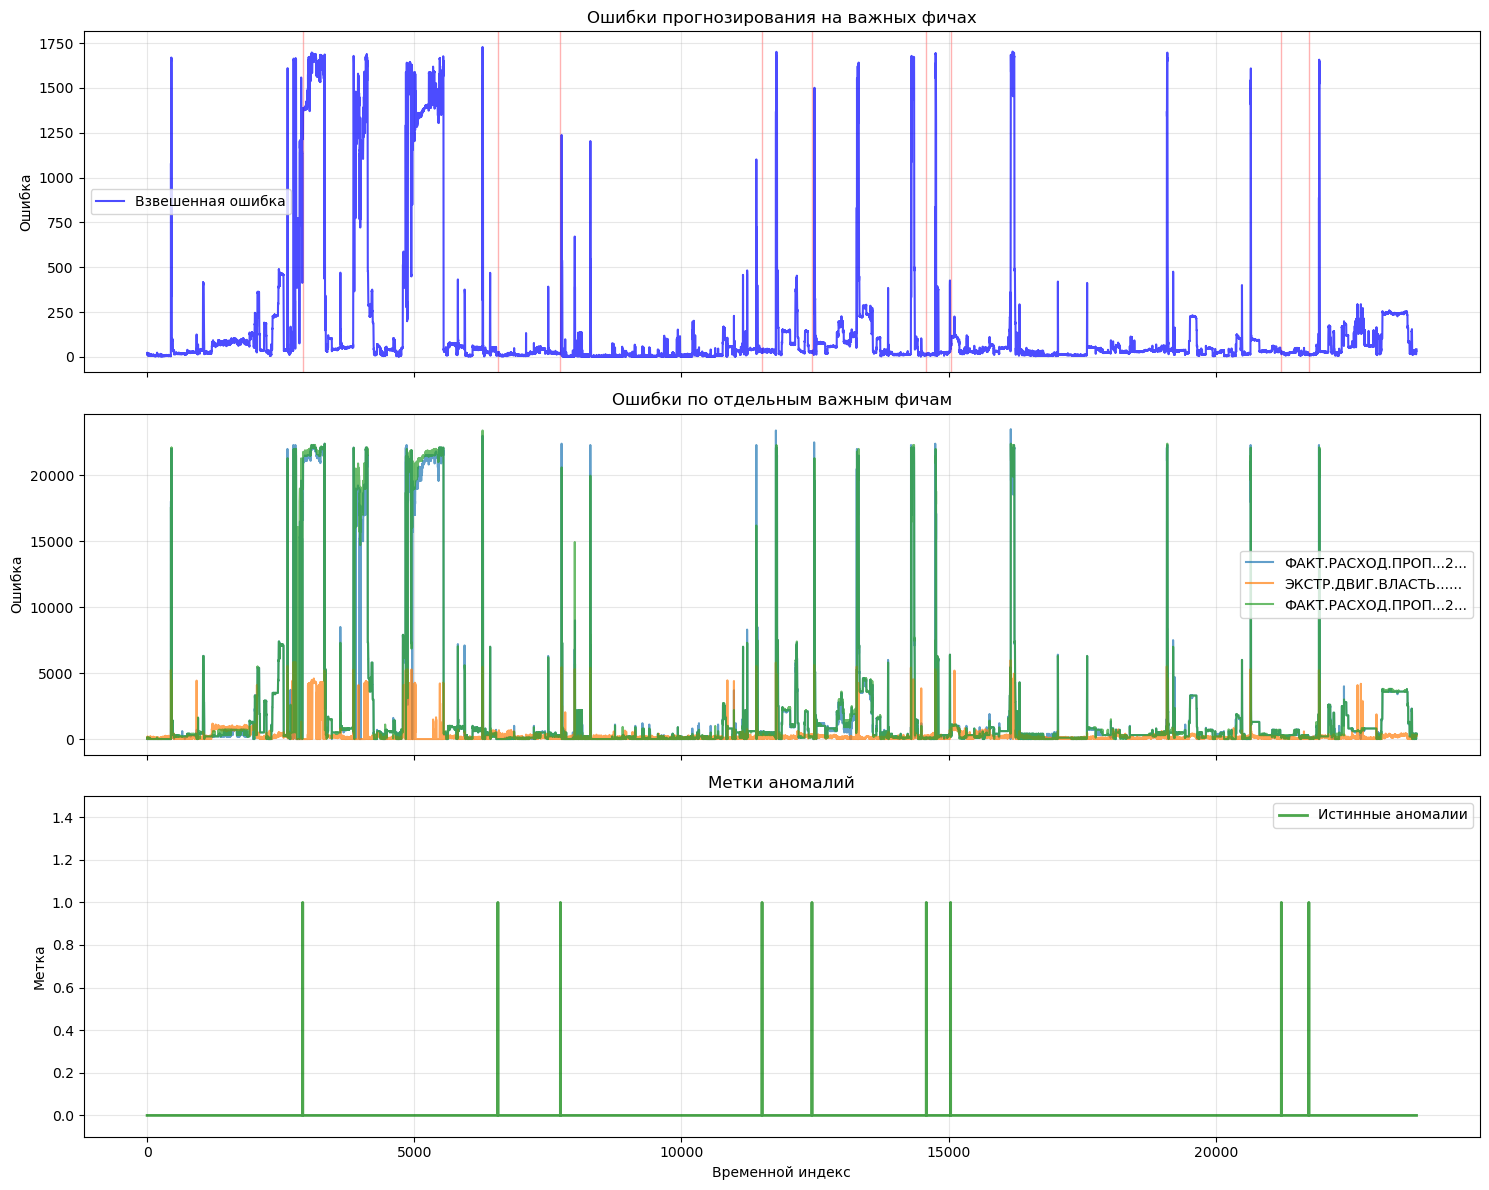


6. Детектирование аномалий с окном 48 часов...
Найдено истинных аномальных регионов: 9
  Регион 1: 2912-2912 (1 точек, 0.2 часов)
  Регион 2: 6565-6565 (1 точек, 0.2 часов)
  Регион 3: 7735-7735 (1 точек, 0.2 часов)
  Регион 4: 11509-11509 (1 точек, 0.2 часов)
  Регион 5: 12443-12443 (1 точек, 0.2 часов)
  Регион 6: 14583-14583 (1 точек, 0.2 часов)
  Регион 7: 15038-15038 (1 точек, 0.2 часов)
  Регион 8: 21228-21228 (1 точек, 0.2 часов)
  Регион 9: 21743-21743 (1 точек, 0.2 часов)
Найдено регионов детекций: 35

МЕТРИКИ ПО РЕГИОНАМ (окно 48 часов)
Всего истинных аномалий: 9
Всего детекций: 35

True Positives (TP): 7 - обнаруженные аномалии
False Positives (FP): 19 - ложные срабатывания
False Negatives (FN): 2 - пропущенные аномалии

Precision (точность): 0.269
Recall (полнота): 0.778
F1-score: 0.400

ДЕТАЛИ ПО АНОМАЛИЯМ:

Аномалия 1:
  Статус: ✓ ОБНАРУЖЕНА
  Позиция: 2912-2912 (длина: 1 точек)
  Обнаружена за 47.8 часов до начала

Аномалия 2:
  Статус: ✓ ОБНАРУЖЕНА
  Позиция: 6565-6565

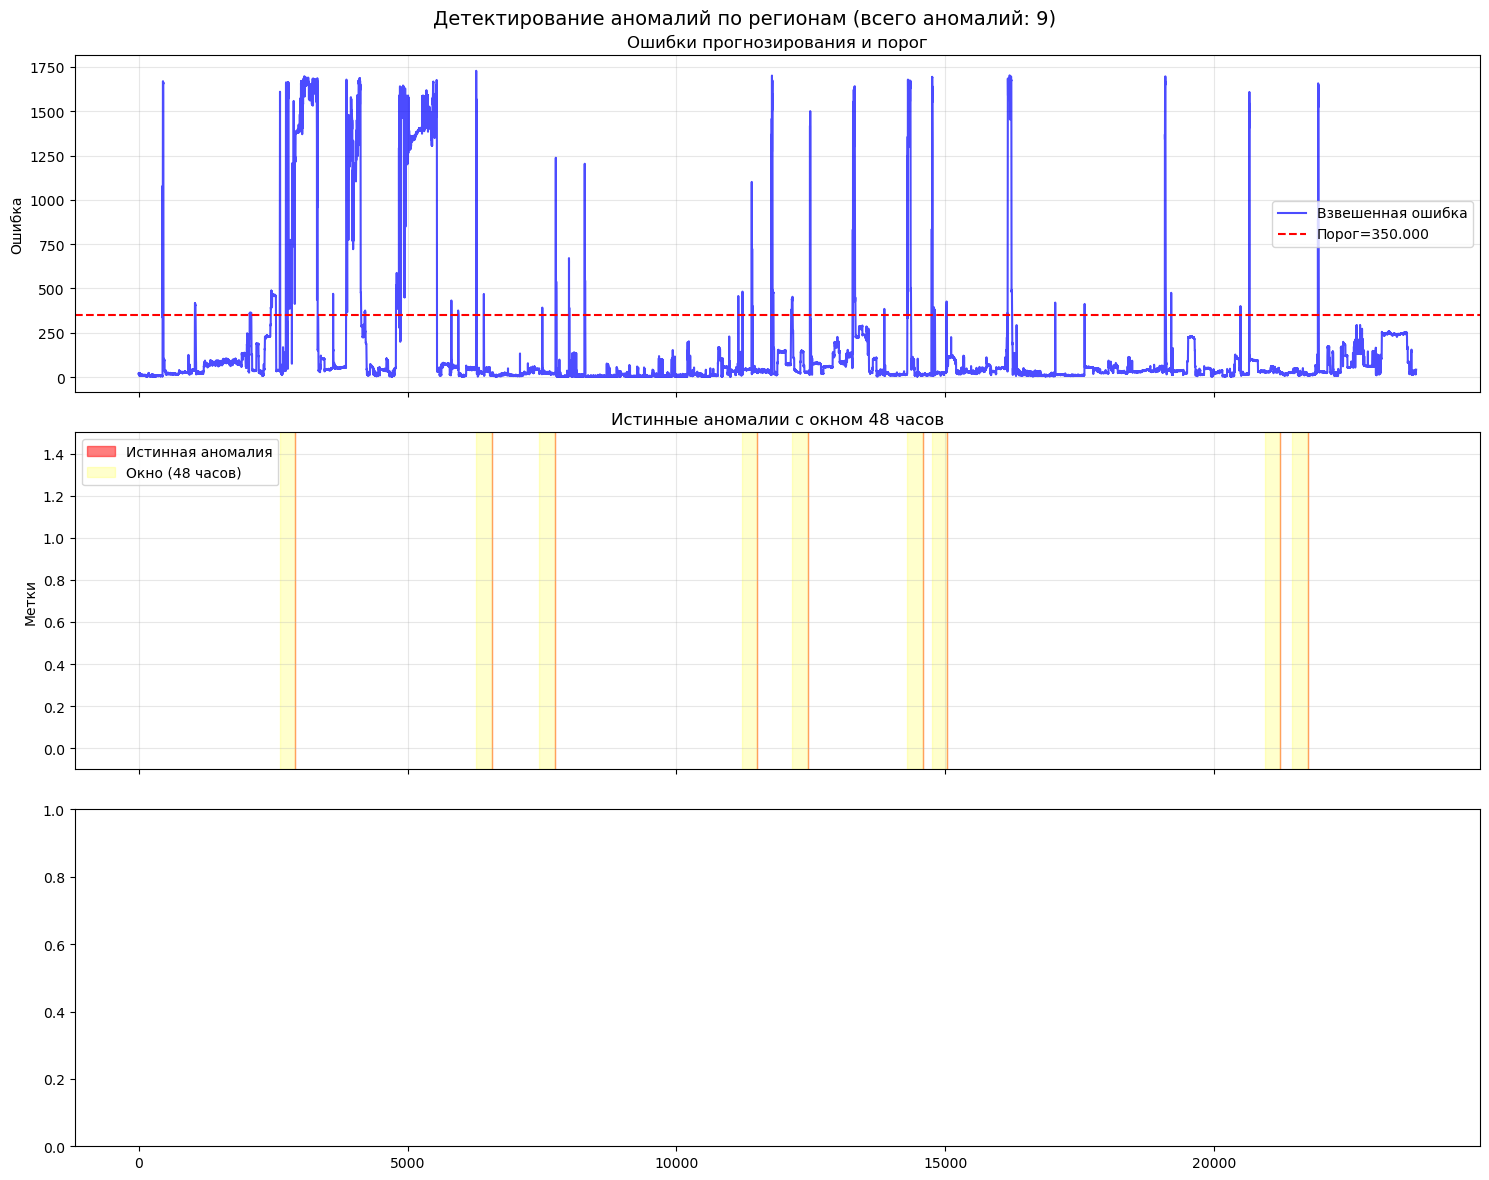


ИТОГОВЫЙ ОТЧЕТ:
Всего аномалий в тесте: 9
Обнаружено: 7
Пропущено: 2
Ложных срабатываний: 19

Precision: 0.269
Recall: 0.778
F1-score: 0.400


In [ ]:
dataset = pd.read_csv('dataset.csv', encoding = 'Windows-1251', index_col = 0, parse_dates = True)
stops = pd.read_csv('stops.csv', index_col = 0, parse_dates = True, date_format=lambda x: pd.to_datetime(x, format='%d.%m.%y %H:%M'))


stops = stops.reset_index()
d = {'vibrosito' : 1, 'stop' : 1}
stops = stops.replace({'type': d})
stops.date = pd.to_datetime(stops.date)
result = pd.merge(dataset, stops, how='left', on='date')
result.type = result.type.fillna(0)

# обрезание части датасета (так как в ней очень много пропусков)

first_valid_index = result[~(result.fillna(-1) == -1).any(axis=1)].index[0]
result = result.loc[first_valid_index:].copy()

# переименовываем таргет

result['target'] = result['type']
result = result.drop("type",axis=1)

# агрегация данных в 10-минутные точки

result = result.set_index('date').sort_index()
aggregated = result.resample("10Min").agg(['max', 'min', 'mean'])
aggregated.columns = [f'{col}_{stat}' for col, stat in aggregated.columns]
df = aggregated
# так как в датасете буквально в паре колонок остались пробелы в 72 точки, было принято решение закрасить их предыдущим значением
df = df.ffill()

# избавляемся от лишних колонок
df = df.drop(["target_min","target_mean"],axis=1)
df = df.rename(columns={'target_max': 'target'})

# анализ сезонности показал присутствие значимой месячной сезонности
# поэтому принято решение добавить в датасет ohe месяца
# а потом использовать их в качестве ковариат

df['month'] = df.index.month

all_months_dummies = pd.get_dummies(df['month'], prefix='month')

for m in range(1, 13):
    col_name = f'month_{m}'
    if col_name not in all_months_dummies.columns:
        all_months_dummies[col_name] = 0

all_months_dummies = all_months_dummies.reindex(
    columns=[f'month_{i}' for i in range(1, 13)]
)

df = pd.concat([df, all_months_dummies], axis=1)
df = df.drop('month', axis=1)

split_date = pd.Timestamp('2017-03-06')

feature_cols = df.columns[:129]
target_col = df.columns[129]
covariate_cols = df.columns[130:]

# Загрузка модели из последнего чекпоинта
checkpoint_files = glob.glob("./checkpoints/checkpoint_*.pt")
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    model = TransformerModel.load(latest_checkpoint)

# Загрузка скалера
with open("./scalers/scaler.pkl", 'rb') as f:
    scaler = pickle.load(f)

# Запуск пайплайна
results = run_anomaly_detection_pipeline(
    model=model,
    scaler=scaler,
    df=df,
    split_date=pd.Timestamp('2017-01-02'),
    # split_date=pd.Timestamp('2017-04-01'),
    feature_cols=feature_cols,
    covariate_cols=covariate_cols,
    target_col='target'
)

In [ ]:
top_features

['ФАКТ.РАСХОД.ПРОП...213FY070_min',
 'ФАКТ.РАСХОД.ПРОП...213FY070_mean',
 'ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A_min',
 'ФАКТ.РАСХОД.ПРОП...213FY070_max',
 'ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A_mean',
 'ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A_max',
 'ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981_min',
 'ЭКСТР.ДВИГ.ПОТОК...214II200A_min',
 'РАСХОД.ЛИНИИ.P.W...214FI205A_min',
 'ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981_mean']

## 5.5. Результаты детектирования аномалий

### 5.5.1. Статистика детектирования

| Показатель | Значение | Интерпретация |
|-----------|----------|---------------|
| **Всего истинных аномалий** | 9 | Количество реальных аномальных событий в тестовом наборе |
| **Всего детекций системы** | 35 | Общее количество срабатываний детектора |
| **True Positives (TP)** | 7 | Аномалии, корректно обнаруженные системой (77.8%) |
| **False Positives (FP)** | 19 | Ложные срабатывания (детекции без реальной аномалии) |
| **False Negatives (FN)** | 2 | Пропущенные аномалии (22.2%) |

### 5.5.2. Метрики качества

**Precision (Точность)**: 0.269  
*Интерпретация*: Из всех срабатываний системы только 26.9% соответствуют реальным аномалиям. Это указывает на высокий уровень ложных срабатываний.

**Recall (Полнота)**: 0.778  
*Интерпретация*: Система обнаруживает 77.8% реальных аномалий, что свидетельствует о хорошей способности к обнаружению.

**F1-score**: 0.400  
*Интерпретация*: Гармоническое среднее precision и recall, отражающее общее качество системы.

## 5.6. Анализ результатов

### 5.6.1. Сильные стороны системы

1. **Высокий recall (0.778)**: Система успешно обнаруживает большинство реальных аномалий:
   - Обнаружено 7 из 9 аномалий (77.8%)
   - Это критически важно для систем безопасности, где пропуск аномалии может иметь серьезные последствия

2. **Эффективное обнаружение критических событий**:
   - Система способна выявлять аномалии за 48 часов до их явного проявления
   - Расширенное временное окно обеспечивает раннее предупреждение

### 5.6.2. Области для улучшения

1. **Высокий уровень ложных срабатываний**:
   - Соотношение TP:FP = 7:19 (примерно 1:2.7)
   - Каждая реальная аномалия сопровождается в среднем 2.7 ложными срабатываниями
   - Это может привести к "усталости оператора" в промышленных системах

2. **Низкая точность (precision)**:
   - Только 26.9% срабатываний соответствуют реальным аномалиям
   - Необходима оптимизация пороговых значений

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6007 (pid 18552), started 7:13:26 ago. (Use '!kill 18552' to kill it.)